<div id="container" style="position:relative;">
<div style="float:left"><h1> Predicting NHL Goal Scoring - Preprocessing & EDA </h1></div>

***BrainStation Data Science Capstone Project*** <br/>
***Author:***  &ensp;    **Taylor Gallivan** <br/>
***Date:*** &ensp; **Sep-Nov 2023** 

## Introduction

This notebook is for Preprocessding & EDA of the player statistic data pulled from the NHL API.  Key preprocessing steps:
1. Evaluate dataset for completeness:  since this data was pulled directly from the NHL's publicly accessible API, we need to run some validation checks to confirm that the data is 1) complete, and 2) accurate.
2. Remove data for seasons prior to 1979-1980 --> prior to this season, there were two professional leagues in North America:  the NHL and the WHA.  The merger of the WHA with the NHL consolidated all of the top hockey talent in North America into a single league.  The merger also resulted in the addition of four more teams to the league, bringing the total number of NHL franchises to 21 teams.  There are some also some limited statistics present for the current ongoing NHL season - the sample size is too small (only a handfull of games per player) so these will be deleted as well.
3. Reorganize dataframe, make naming syntax consistent.
4. Convert all time on ice statistics from string objects to float values for total number of minutes played.
5. Remove one of either `pim` or `penalty_minutes` --> these fields ostensibly contain the same information.  Run some analysis to confirm / pick one to drop.
6. Make team names consistent --> franchises have relocated or changed names over the years and we want each franchise to be represented by only a single name for consistency and interpretability by the model(s).  All franchises will be assigned the abbreviation code of the team that currently represents them.
7. Fix null values using averages based on `position_name`
8. Flatten the `sequence_number` column which indicated when a player was traded midseason.  The goal is to only have a single entry per year, per player.  A new columns called `midseason_trades` will replace `sequence_number` to indicate that a player was traded midseason during that NHL season.
9. Remove entries in the DataFrame where a player played fewer than 10% of a full season (i.e., less than 8 games).  Small samples are more prone to skewed or biased data.
10. Convert player heights (`height`) from string object datatype to a numerical datatype.  Height are currently stored in the format {feet}' {inches}" like 6'8" --> convert this to just inches.
11. Check for zeroes and duplicates remaining in the dataset --> solve for any remaining.


In [1]:
# import packages
import pandas as pd
pd.set_option('display.max_columns', None)
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Evaluating DataSet for Completeness

Since this dataset was manually compiled by pulling data from the NHL API, I need to run some preliminary checks to ensure the desired dataset was accurately compiled.

In [2]:
# read in the dataset
df = pd.read_csv('df_main.csv')

In [3]:
df.head()

,player_id,name,position_code,season,sequenceNumber,stat_assists,stat_goals,stat_games,stat_points,team_name,...,season_end,weight,height,shot_dir,birth_date,age,position_name,position_type,birth_country,nationality
0,8445000,Dave Andreychuk,L,19821983,1,23.0,14.0,43,37.0,Buffalo Sabres,...,1983,225,"6' 4""",R,1963-09-29,19,Left Wing,Forward,CAN,CAN
1,8445000,Dave Andreychuk,L,19831984,1,42.0,38.0,78,80.0,Buffalo Sabres,...,1984,225,"6' 4""",R,1963-09-29,20,Left Wing,Forward,CAN,CAN
2,8445000,Dave Andreychuk,L,19841985,1,30.0,31.0,64,61.0,Buffalo Sabres,...,1985,225,"6' 4""",R,1963-09-29,21,Left Wing,Forward,CAN,CAN
3,8445000,Dave Andreychuk,L,19851986,1,51.0,36.0,80,87.0,Buffalo Sabres,...,1986,225,"6' 4""",R,1963-09-29,22,Left Wing,Forward,CAN,CAN
4,8445000,Dave Andreychuk,L,19861987,1,48.0,25.0,77,73.0,Buffalo Sabres,...,1987,225,"6' 4""",R,1963-09-29,23,Left Wing,Forward,CAN,CAN


In [4]:
# Transpose header so we can check that all columns are present, with correct data
df.T.head(46)

,0,1,2,3,4,5,6,7,8,9,...,37785,37786,37787,37788,37789,37790,37791,37792,37793,37794
player_id,8445000,8445000,8445000,8445000,8445000,8445000,8445000,8445000,8445000,8445000,...,8482109,8482109,8482116,8482116,8482116,8482116,8482245,8482245,8482245,8482245
name,Dave Andreychuk,Dave Andreychuk,Dave Andreychuk,Dave Andreychuk,Dave Andreychuk,Dave Andreychuk,Dave Andreychuk,Dave Andreychuk,Dave Andreychuk,Dave Andreychuk,...,Alexis Lafrenière,Alexis Lafrenière,Tim Stützle,Tim Stützle,Tim Stützle,Tim Stützle,Artem Zub,Artem Zub,Artem Zub,Artem Zub
position_code,L,L,L,L,L,L,L,L,L,L,...,L,L,C,C,C,C,D,D,D,D
season,19821983,19831984,19841985,19851986,19861987,19871988,19881989,19891990,19901991,19911992,...,20222023,20232024,20202021,20212022,20222023,20232024,20202021,20212022,20222023,20232024
sequenceNumber,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
stat_assists,23.0,42.0,30.0,51.0,48.0,48.0,24.0,42.0,33.0,50.0,...,23.0,0.0,17.0,36.0,51.0,4.0,11.0,16.0,7.0,2.0
stat_goals,14.0,38.0,31.0,36.0,25.0,30.0,28.0,40.0,36.0,41.0,...,16.0,2.0,12.0,22.0,39.0,2.0,3.0,6.0,3.0,1.0
stat_games,43,78,64,80,77,80,56,73,80,80,...,81,5,53,79,78,5,47,81,53,4
stat_points,37.0,80.0,61.0,87.0,73.0,78.0,52.0,82.0,69.0,91.0,...,39.0,2.0,29.0,58.0,90.0,6.0,14.0,22.0,10.0,3.0
team_name,Buffalo Sabres,Buffalo Sabres,Buffalo Sabres,Buffalo Sabres,Buffalo Sabres,Buffalo Sabres,Buffalo Sabres,Buffalo Sabres,Buffalo Sabres,Buffalo Sabres,...,New York Rangers,New York Rangers,Ottawa Senators,Ottawa Senators,Ottawa Senators,Ottawa Senators,Ottawa Senators,Ottawa Senators,Ottawa Senators,Ottawa Senators


Since all of the data was manually pulled from the NHL's public API, we want to perform some checks to see if the data that was collected matches league data.  The first check will be printing all of the stats for a player with a lengthy career.  NHL legend Jaromir Jagr played in 24 NHL seasons, with stints on 9 different teams.  There were also gaps in his career where he returned to play in his native Czech Republic.  These factors will be a good test to see if the API pull requests functioned as designed.  During his career, Jagr was traded mid-season a total of three times, so it is expected that the resulting DataFrame will have 27 rows.  

In [5]:
print(df[df['name'] == 'Jaromir Jagr'])

      player_id          name position_code    season  sequenceNumber  \
9649    8448208  Jaromir Jagr             R  19901991               1   
9650    8448208  Jaromir Jagr             R  19911992               1   
9651    8448208  Jaromir Jagr             R  19921993               1   
9652    8448208  Jaromir Jagr             R  19931994               1   
9653    8448208  Jaromir Jagr             R  19941995               1   
9654    8448208  Jaromir Jagr             R  19951996               1   
9655    8448208  Jaromir Jagr             R  19961997               1   
9656    8448208  Jaromir Jagr             R  19971998               1   
9657    8448208  Jaromir Jagr             R  19981999               1   
9658    8448208  Jaromir Jagr             R  19992000               1   
9659    8448208  Jaromir Jagr             R  20002001               1   
9660    8448208  Jaromir Jagr             R  20012002               1   
9661    8448208  Jaromir Jagr             R  200220

The resulting DataFrame has 27 rows as expected, and the major stats look accurate, including Jagr's point totals and seasons that he played in.  For reference, Jagr's career statistics can be viewed at the following web link:  https://www.nhl.com/player/jaromir-jagr-8448208

Next, let's check that the top goal scorers of all time are present in the DataFrame, and that their goal totals are accurate.  For reference, a list of the NHL's top all-time goal scorers along with their goal totals can be found at the following web address link:  
https://records.nhl.com/records/skater-records/goals/most-goals-career

In [6]:
# New DataFrame grouping players
top_scorers = df.groupby(['player_id', 'name'])['stat_goals'].sum().reset_index()

# Set a threshold for a 'top' goal scorer
top_scorers = top_scorers[top_scorers['stat_goals'] > 650]

# Sort the 'top' goal scorers by number of goals scored
top_scorers_sorted = top_scorers.sort_values(by='stat_goals', ascending=False).reset_index()

# Display results
top_scorers_sorted

,index,player_id,name,stat_goals
0,655,8447400,Wayne Gretzky,894.0
1,2486,8471214,Alex Ovechkin,822.0
2,808,8448000,Gordie Howe,801.0
3,875,8448208,Jaromir Jagr,766.0
4,836,8448091,Brett Hull,741.0
5,383,8446430,Marcel Dionne,731.0
6,476,8446722,Phil Esposito,717.0
7,571,8447067,Mike Gartner,708.0
8,1242,8449573,Mark Messier,694.0
9,1618,8452578,Steve Yzerman,692.0


The list of the top scorers is accurate, save for the goal totals for Alex Ovechkin, who is still playing and has scored goals in the current 2023-2024 season.  One of the further processing steps will be to remove any stats from the 2023-2024 season that are in the dataset.

Now we will run a few standard commands to get insight into the datatypes, column names, and presence of missing/null values.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37795 entries, 0 to 37794
Data columns (total 46 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   player_id                  37795 non-null  int64  
 1   name                       37795 non-null  object 
 2   position_code              37795 non-null  object 
 3   season                     37795 non-null  int64  
 4   sequenceNumber             37795 non-null  int64  
 5   stat_assists               37795 non-null  float64
 6   stat_goals                 37795 non-null  float64
 7   stat_games                 37795 non-null  int64  
 8   stat_points                37795 non-null  float64
 9   team_name                  37795 non-null  object 
 10  team_link                  37795 non-null  object 
 11  league_name                37795 non-null  object 
 12  league_link                37795 non-null  object 
 13  stat_pim                   37795 non-null  flo

In [8]:
df.describe()

,player_id,season,sequenceNumber,stat_assists,stat_goals,stat_games,stat_points,stat_pim,stat_penaltyMinutes,team_id,...,stat_shortHandedPoints,stat_plusMinus,stat_hits,stat_faceOffPct,stat_blocked,stat_shifts,season_start_yr,season_end,weight,age
count,3.779500e+04,3.779500e+04,37795.000000,37795.000000,37795.000000,37795.000000,37795.000000,37795.000000,37795.000000,37795.000000,...,36900.000000,34167.000000,18767.000000,18769.000000,18769.000000,18769.000000,37795.000000,37795.000000,37795.000000,37795.000000
mean,8.458347e+06,1.992300e+07,1.092790,15.206377,9.320995,50.430533,24.527371,41.760656,41.760656,16.277180,...,0.629431,0.109053,60.491554,28.485748,29.589376,1116.591934,1992.100278,1993.100278,197.409234,26.586612
std,1.153667e+04,2.280050e+05,0.303426,14.201422,10.154675,25.621672,22.965353,44.387377,44.387377,11.512013,...,1.269621,12.718257,52.454420,26.443458,38.261075,662.338808,22.798225,22.798225,18.133529,4.431540
min,8.444894e+06,1.917192e+07,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,-69.000000,0.000000,0.000000,0.000000,0.000000,1917.000000,1918.000000,0.000000,16.000000
25%,8.448049e+06,1.980198e+07,1.000000,4.000000,2.000000,29.000000,7.000000,12.000000,12.000000,7.000000,...,0.000000,-6.000000,21.000000,0.000000,0.000000,514.000000,1980.000000,1981.000000,185.000000,23.000000
50%,8.452371e+06,1.996200e+07,1.000000,11.000000,6.000000,56.000000,18.000000,29.000000,29.000000,16.000000,...,0.000000,-1.000000,47.000000,33.330000,16.000000,1179.000000,1996.000000,1997.000000,198.000000,26.000000
75%,8.470041e+06,2.010201e+07,1.000000,22.000000,14.000000,73.000000,37.000000,56.000000,56.000000,23.000000,...,1.000000,6.000000,86.000000,50.000000,41.000000,1664.000000,2010.000000,2011.000000,210.000000,30.000000
max,8.482245e+06,2.023202e+07,4.000000,163.000000,92.000000,84.000000,215.000000,472.000000,472.000000,58.000000,...,23.000000,124.000000,386.000000,100.000000,283.000000,2881.000000,2023.000000,2024.000000,265.000000,51.000000


#### Remove Unwanted Columns
The data collection process resulted in several columns being imported that are not needed - delete them. 

In [5]:
# print column names for reference
print(df.columns)

Index(['player_id', 'name', 'sequenceNumber', 'stat_assists', 'stat_goals',
       'stat_games', 'stat_points', 'team_name', 'stat_pim',
       'stat_penaltyMinutes', 'team_id', 'stat_shots', 'stat_powerPlayGoals',
       'stat_powerPlayPoints', 'stat_shotPct', 'stat_gameWinningGoals',
       'stat_shortHandedGoals', 'stat_shortHandedPoints', 'stat_plusMinus',
       'stat_timeOnIce', 'stat_hits', 'stat_powerPlayTimeOnIce',
       'stat_evenTimeOnIce', 'stat_shortHandedTimeOnIce', 'stat_blocked',
       'stat_shifts', 'season_start_yr', 'season_start_dt', 'season_end',
       'weight', 'height', 'shot_dir', 'birth_date', 'age', 'position_name',
       'position_type'],
      dtype='object')


In [3]:
df = df.drop(columns=['position_code', 'season', 'team_link', 'league_name', 'league_link', 'league_id', \
                      'stat_overTimeGoals', 'stat_faceOffPct', 'birth_country', 'nationality'])
df

,player_id,name,sequenceNumber,stat_assists,stat_goals,stat_games,stat_points,team_name,stat_pim,stat_penaltyMinutes,...,season_start_yr,season_start_dt,season_end,weight,height,shot_dir,birth_date,age,position_name,position_type
0,8445000,Dave Andreychuk,1,23.0,14.0,43,37.0,Buffalo Sabres,16.0,16,...,1982,1982-09-30,1983,225,"6' 4""",R,1963-09-29,19,Left Wing,Forward
1,8445000,Dave Andreychuk,1,42.0,38.0,78,80.0,Buffalo Sabres,40.0,40,...,1983,1983-09-30,1984,225,"6' 4""",R,1963-09-29,20,Left Wing,Forward
2,8445000,Dave Andreychuk,1,30.0,31.0,64,61.0,Buffalo Sabres,54.0,54,...,1984,1984-09-30,1985,225,"6' 4""",R,1963-09-29,21,Left Wing,Forward
3,8445000,Dave Andreychuk,1,51.0,36.0,80,87.0,Buffalo Sabres,61.0,61,...,1985,1985-09-30,1986,225,"6' 4""",R,1963-09-29,22,Left Wing,Forward
4,8445000,Dave Andreychuk,1,48.0,25.0,77,73.0,Buffalo Sabres,44.0,44,...,1986,1986-09-30,1987,225,"6' 4""",R,1963-09-29,23,Left Wing,Forward
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37790,8482116,Tim Stützle,1,4.0,2.0,5,6.0,Ottawa Senators,8.0,8,...,2023,2023-09-30 00:00:00,2024,197,"6' 0""",L,2002-01-15 00:00:00,21,Center,Forward
37791,8482245,Artem Zub,1,11.0,3.0,47,14.0,Ottawa Senators,26.0,26,...,2020,2020-09-30 00:00:00,2021,204,"6' 3""",R,1995-10-03 00:00:00,25,Defenseman,Defenseman
37792,8482245,Artem Zub,1,16.0,6.0,81,22.0,Ottawa Senators,60.0,60,...,2021,2021-09-30 00:00:00,2022,204,"6' 3""",R,1995-10-03 00:00:00,26,Defenseman,Defenseman
37793,8482245,Artem Zub,1,7.0,3.0,53,10.0,Ottawa Senators,39.0,39,...,2022,2022-09-30 00:00:00,2023,204,"6' 3""",R,1995-10-03 00:00:00,27,Defenseman,Defenseman


#### Remove Unwanted Seasons
Stats from the present season (2023-2024) and from the seasons prior to 1979-1980 to be removed.

In [4]:
# Check the value counts for different seasons
# Change settings to display all results
pd.set_option('display.max_rows', None)

value_counts_df = df['season_start_yr'].value_counts().reset_index()
value_counts_df.columns = ['season_start_yr', 'count']
value_counts_df = value_counts_df.sort_values(by='season_start_yr')

print(value_counts_df)

     season_start_yr  count
105             1917      8
104             1918     11
103             1919     13
102             1920     18
101             1921     19
100             1922     22
99              1923     24
98              1924     35
97              1925     49
93              1926     78
92              1927     85
89              1928     97
84              1929    101
73              1930    113
85              1931    101
65              1932    121
62              1933    127
61              1934    129
66              1935    121
60              1936    129
63              1937    124
75              1938    112
86              1939    101
91              1940     87
90              1941     93
94              1942     77
96              1943     67
95              1944     70
88              1945     97
87              1946     98
82              1947    103
83              1948    102
80              1949    106
72              1950    114
74              1951

In [6]:
# Create loop up to remove entries from unwanted seasons
for ind, value in enumerate(df['season_start_yr']):
    if (value==2023) or (value<1979):
        df.drop([ind], inplace=True)
    else:
        pass

In [7]:
# Reprint value counts of 'season_start_yr'
value_counts_df = df['season_start_yr'].value_counts().reset_index()
value_counts_df.columns = ['season_start_yr', 'count']
value_counts_df = value_counts_df.sort_values(by='season_start_yr')

print(value_counts_df)

    season_start_yr  count
42             1979    479
41             1980    486
38             1981    517
40             1982    498
37             1983    537
39             1984    510
35             1985    541
36             1986    540
34             1987    559
32             1988    582
33             1989    568
31             1990    583
28             1991    642
29             1992    609
24             1993    683
26             1994    670
16             1995    736
23             1996    703
22             1997    707
9              1998    751
6              1999    759
3              2000    769
0              2001    776
1              2002    774
2              2003    772
4              2005    763
5              2006    760
14             2007    737
12             2008    742
13             2009    739
15             2010    736
17             2011    735
20             2012    716
19             2013    728
10             2014    747
11             2015    743
1

In [8]:
# Check shape of resulting DataFrame
df.shape

(28777, 36)

The above two blocks of code confirm that the major cleaning steps have been correctly implemented.

Saving condensed dataset so that above steps do not need to be executed in future.

In [9]:
# Save condensed dataset
# df.to_csv('NHL_data_condensed.csv', index=False)

## *Checkpoint*

In [33]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

### Further Data Cleaning

Many of the columns are prefixed with 'stat_' - the prefix is unnecessary and can be removed.  We can also use regex to make all column names consistent:  
- underscores between words
- all letters lowercase 
- 'time_on_ice' can be shortened to 'toi'

In [93]:
# Load in the condensed dataset
df = pd.read_csv('NHL_data_condensed.csv')

In [94]:
df.shape

(28777, 36)

In [95]:
df.head()

,player_id,name,sequenceNumber,stat_assists,stat_goals,stat_games,stat_points,team_name,stat_pim,stat_penaltyMinutes,...,season_start_yr,season_start_dt,season_end,weight,height,shot_dir,birth_date,age,position_name,position_type
0,8445000,Dave Andreychuk,1,23.0,14.0,43,37.0,Buffalo Sabres,16.0,16,...,1982,1982-09-30,1983,225,"6' 4""",R,1963-09-29,19,Left Wing,Forward
1,8445000,Dave Andreychuk,1,42.0,38.0,78,80.0,Buffalo Sabres,40.0,40,...,1983,1983-09-30,1984,225,"6' 4""",R,1963-09-29,20,Left Wing,Forward
2,8445000,Dave Andreychuk,1,30.0,31.0,64,61.0,Buffalo Sabres,54.0,54,...,1984,1984-09-30,1985,225,"6' 4""",R,1963-09-29,21,Left Wing,Forward
3,8445000,Dave Andreychuk,1,51.0,36.0,80,87.0,Buffalo Sabres,61.0,61,...,1985,1985-09-30,1986,225,"6' 4""",R,1963-09-29,22,Left Wing,Forward
4,8445000,Dave Andreychuk,1,48.0,25.0,77,73.0,Buffalo Sabres,44.0,44,...,1986,1986-09-30,1987,225,"6' 4""",R,1963-09-29,23,Left Wing,Forward


#### REGEX on Column Names
Use REGEX and other string manipulation techniques to remove the 'stat_' prefix from gameplay statistics.  Make column name syntax consistent 

In [96]:
# Import regex library
import re

# Define the prefix to remove
prefix_to_remove = 'stat_'

# Use a list comprehension to remove the unwanted prefix
new_columns = [col.replace(prefix_to_remove, '') for col in df.columns]

# Use another list comprehension with regex to make column name syntax consistent
new_columns2 = [re.sub(r'([a-z])([A-Z])', r'\1_\2', col).lower() for  col in new_columns]

# Use another list comprehension with regex to change time_on_ice to toi
new_columns3 = [re.sub(r'(time_on_ice)', r'toi', col).lower() for  col in new_columns2]

# Replace column names in the DataFrame with new ones.
df.columns = new_columns3

In [97]:
# Sanity check
df.T.head(36)

,0,1,2,3,4,5,6,7,8,9,...,28767,28768,28769,28770,28771,28772,28773,28774,28775,28776
player_id,8445000,8445000,8445000,8445000,8445000,8445000,8445000,8445000,8445000,8445000,...,8481624,8482109,8482109,8482109,8482116,8482116,8482116,8482245,8482245,8482245
name,Dave Andreychuk,Dave Andreychuk,Dave Andreychuk,Dave Andreychuk,Dave Andreychuk,Dave Andreychuk,Dave Andreychuk,Dave Andreychuk,Dave Andreychuk,Dave Andreychuk,...,Ilya Mikheyev,Alexis Lafrenière,Alexis Lafrenière,Alexis Lafrenière,Tim Stützle,Tim Stützle,Tim Stützle,Artem Zub,Artem Zub,Artem Zub
sequence_number,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
assists,23.0,42.0,30.0,51.0,48.0,48.0,24.0,42.0,33.0,50.0,...,15.0,9.0,12.0,23.0,17.0,36.0,51.0,11.0,16.0,7.0
goals,14.0,38.0,31.0,36.0,25.0,30.0,28.0,40.0,36.0,41.0,...,13.0,12.0,19.0,16.0,12.0,22.0,39.0,3.0,6.0,3.0
games,43,78,64,80,77,80,56,73,80,80,...,46,56,79,81,53,79,78,47,81,53
points,37.0,80.0,61.0,87.0,73.0,78.0,52.0,82.0,69.0,91.0,...,28.0,21.0,31.0,39.0,29.0,58.0,90.0,14.0,22.0,10.0
team_name,Buffalo Sabres,Buffalo Sabres,Buffalo Sabres,Buffalo Sabres,Buffalo Sabres,Buffalo Sabres,Buffalo Sabres,Buffalo Sabres,Buffalo Sabres,Buffalo Sabres,...,Vancouver Canucks,New York Rangers,New York Rangers,New York Rangers,Ottawa Senators,Ottawa Senators,Ottawa Senators,Ottawa Senators,Ottawa Senators,Ottawa Senators
pim,16.0,40.0,54.0,61.0,44.0,112.0,40.0,42.0,32.0,71.0,...,2.0,8.0,37.0,33.0,14.0,37.0,54.0,26.0,60.0,39.0
penalty_minutes,16,40,54,61,44,112,40,42,32,71,...,2,8,37,33,14,37,54,26,60,39


Let's rename a couple of columns for consistency / interpretability

In [98]:
df.rename(columns={'shot_dir': 'shot_direction', 'season_end': 'season_end_yr', 'games': 'games_played', 
                   'age': 'player_age', 'toi': 'total_toi', 'even_toi': 'even_strength_toi'}, inplace=True)

In [99]:
# Sanity check
df.columns

Index(['player_id', 'name', 'sequence_number', 'assists', 'goals',
       'games_played', 'points', 'team_name', 'pim', 'penalty_minutes',
       'team_id', 'shots', 'power_play_goals', 'power_play_points', 'shot_pct',
       'game_winning_goals', 'short_handed_goals', 'short_handed_points',
       'plus_minus', 'total_toi', 'hits', 'power_play_toi',
       'even_strength_toi', 'short_handed_toi', 'blocked', 'shifts',
       'season_start_yr', 'season_start_dt', 'season_end_yr', 'weight',
       'height', 'shot_direction', 'birth_date', 'player_age', 'position_name',
       'position_type'],
      dtype='object')

First lets rearrange the DataFrame and drop statistical columns that we are confident will have little to no predictive power in our analysis.  Columns can be categorized as follows:

Peronal stats:  8
- `player_id`
- `name` 
- `birth_date` 
- `weight`
- `height`
- `position_name` 
- `position_type`
- `shot_direction`

General season statistics:  18
- `season_start_yr` 
- `season_start_dt`
- `season_end_yr`
- `player_age`
- `team_name`
- `team_id`
- `sequence_number`
- `games_played`
- `shifts`
- `assists`
- `points`
- `power_play_points`
- `short_handed_points`
- `plus_minus`
- `pim`
- `penalty_minutes`
- `hits`
- `blocked`

Goal statistics:  6
- `goals`
- `game_winning_goals`
- `power_play_goals`
- `short_handed_goals`
- `shots`
- `shot_pct`

Time on ice statistics:  4
- `total_toi`
- `even_strength_toi`
- `power_play_toi`
- `short_handed_toi`

In [100]:
# group statistics into temporary DataFrames
personal_stats = df.loc[:, ['player_id', 'name', 'birth_date', 'weight', 'height', 'position_name', 'position_type', 'shot_direction']]
season_stats = df.loc[:, ['season_start_yr', 'season_start_dt', 'season_end_yr', 'player_age', 'team_name', 'team_id', 'sequence_number', \
                         'games_played', 'shifts', 'assists', 'points', 'power_play_points', 'short_handed_points', 'plus_minus', \
                         'pim', 'penalty_minutes', 'hits', 'blocked']]
goal_stats = df.loc[:, ['goals', 'game_winning_goals', 'power_play_goals', 'short_handed_goals', 'shots', 'shot_pct']]
toi_stats = df.loc[:, ['total_toi', 'even_strength_toi', 'power_play_toi', 'short_handed_toi']]

In [101]:
# rejoin grouped statistics into organized DataFrame
df2 = personal_stats.join(goal_stats.join(season_stats.join(toi_stats)))

In [102]:
# Sanity check
df2.columns

Index(['player_id', 'name', 'birth_date', 'weight', 'height', 'position_name',
       'position_type', 'shot_direction', 'goals', 'game_winning_goals',
       'power_play_goals', 'short_handed_goals', 'shots', 'shot_pct',
       'season_start_yr', 'season_start_dt', 'season_end_yr', 'player_age',
       'team_name', 'team_id', 'sequence_number', 'games_played', 'shifts',
       'assists', 'points', 'power_play_points', 'short_handed_points',
       'plus_minus', 'pim', 'penalty_minutes', 'hits', 'blocked', 'total_toi',
       'even_strength_toi', 'power_play_toi', 'short_handed_toi'],
      dtype='object')

In [103]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28777 entries, 0 to 28776
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   player_id            28777 non-null  int64  
 1   name                 28777 non-null  object 
 2   birth_date           28777 non-null  object 
 3   weight               28777 non-null  int64  
 4   height               28777 non-null  object 
 5   position_name        28777 non-null  object 
 6   position_type        28777 non-null  object 
 7   shot_direction       28777 non-null  object 
 8   goals                28777 non-null  float64
 9   game_winning_goals   28777 non-null  float64
 10  power_play_goals     28777 non-null  float64
 11  short_handed_goals   28777 non-null  float64
 12  shots                28777 non-null  float64
 13  shot_pct             28707 non-null  float64
 14  season_start_yr      28777 non-null  int64  
 15  season_start_dt      28777 non-null 

#### Fixing Penalty Minutes
There are two features that both relate to penalty minutes:  `pim` and `penalty_minutes`.  Perform analysis to 1) confirm if they hold the same data, and 2) condense the data into a single feature.

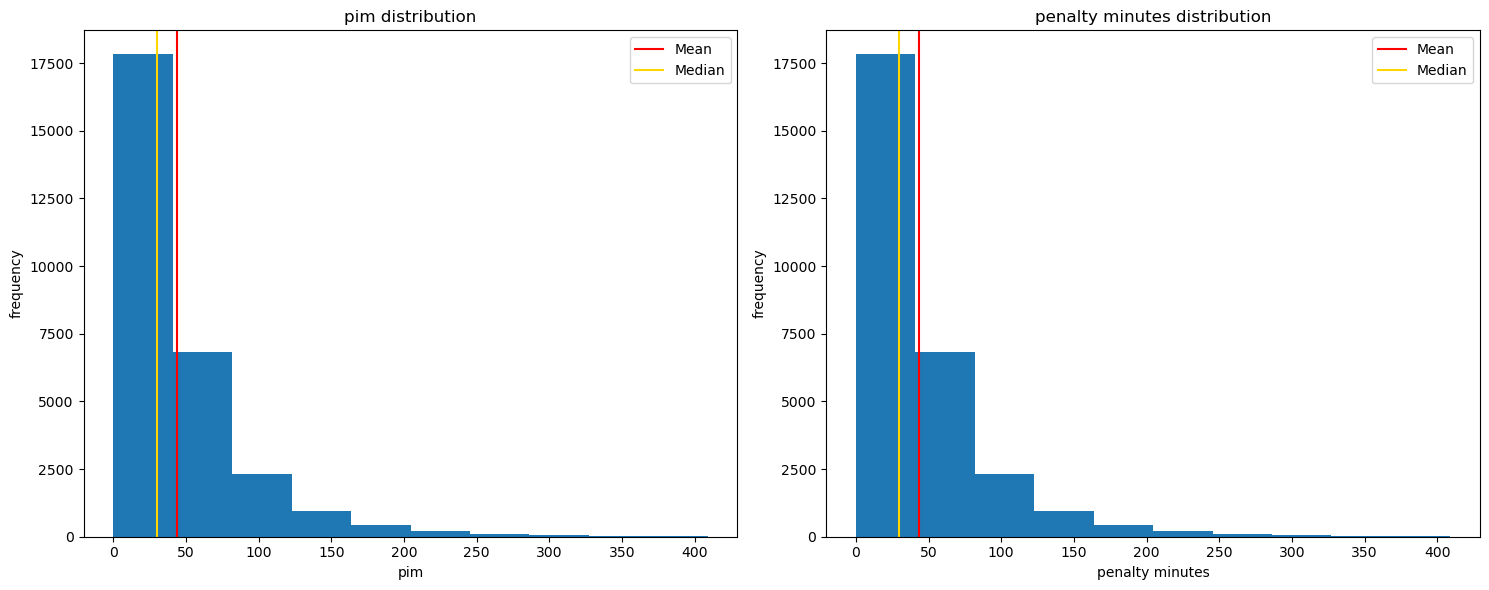

In [104]:
# plot distribution of both features
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].hist(df2['pim'])
axes[0].set_title('pim distribution')
axes[0].set_xlabel('pim')
axes[0].set_ylabel('frequency')
axes[0].axvline(df2['pim'].mean(), c='red', label='Mean')
axes[0].axvline(df2['pim'].median(), c='gold', label='Median')
axes[0].legend()

axes[1].hist(df2['penalty_minutes'])
axes[1].set_title('penalty minutes distribution')
axes[1].set_xlabel('penalty minutes')
axes[1].set_ylabel('frequency')
axes[1].axvline(df2['penalty_minutes'].mean(), c='red', label='Mean')
axes[1].axvline(df2['penalty_minutes'].median(), c='gold', label='Median')
axes[1].legend()

# Adjust spacing between the two subplots
plt.tight_layout()

plt.show()

In [105]:
# Create df holding the two columns of interest
penalty_df = df2[['pim', 'penalty_minutes']]

# compare stastical distributions
penalty_df.describe()

,pim,penalty_minutes
count,28777.000000,28777.000000
mean,43.567189,43.567189
std,45.853972,45.853972
min,0.000000,0.000000
25%,14.000000,14.000000
50%,30.000000,30.000000
75%,58.000000,58.000000
max,409.000000,409.000000


`pim` and `penalty_minutes` contain identical data, save for the fact that values of `pim` are float datatypes, whereas values of `penalty_minutes` are integer datatypes.  `penalty_minutes` is more descriptive, drop `pim`.

In [106]:
# drop 'pim'
df2.drop(columns=['pim'], inplace=True)

In [107]:
# sanity check
df2.shape

(28777, 35)

#### More Columns to Drop
While processing it became apparent that two more columns needed to be dropped:
- shot pct - which will be recalculated after the dataset is flattened for the players that were traded mid-season
- shot direction - there are 78 entries with 'unknown' values.  This feature was not expected to have much predictive value anyways so we will just drop it
- season start date - the only piece of valuable information contained in this column is the date for which a player's age is calculated:  a player's age for a given season is calculated relative to September 30th of the `season_start_yr`
- birth date - there are no null values for age, so this features is not necessary

In [108]:
# drop 'shot_direction', 'shot_pct', 'season_start_dt', 'birth_date'
df2 = df2.drop(columns=['shot_direction', 'shot_pct', 'season_start_dt', 'birth_date'])

# Sanity check
df2.shape

(28777, 31)

In [109]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28777 entries, 0 to 28776
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   player_id            28777 non-null  int64  
 1   name                 28777 non-null  object 
 2   weight               28777 non-null  int64  
 3   height               28777 non-null  object 
 4   position_name        28777 non-null  object 
 5   position_type        28777 non-null  object 
 6   goals                28777 non-null  float64
 7   game_winning_goals   28777 non-null  float64
 8   power_play_goals     28777 non-null  float64
 9   short_handed_goals   28777 non-null  float64
 10  shots                28777 non-null  float64
 11  season_start_yr      28777 non-null  int64  
 12  season_end_yr        28777 non-null  int64  
 13  player_age           28777 non-null  int64  
 14  team_name            28777 non-null  object 
 15  team_id              28777 non-null 

## *Checkpoint*

**Save:**

In [111]:
df2.shape

(28777, 31)

In [110]:
# Save progress
# df2.to_csv('NHL_data_condensed_2.csv', index=False)

**Load:**

In [240]:
# Load the data back in
df = pd.read_csv('NHL_data_condensed_2.csv')

In [241]:
df.shape

(28777, 31)

In [242]:
df.head()

,player_id,name,weight,height,position_name,position_type,goals,game_winning_goals,power_play_goals,short_handed_goals,...,power_play_points,short_handed_points,plus_minus,penalty_minutes,hits,blocked,total_toi,even_strength_toi,power_play_toi,short_handed_toi
0,8445000,Dave Andreychuk,225,"6' 4""",Left Wing,Forward,14.0,1.0,3.0,0.0,...,16.0,0.0,4.0,16,NaN,NaN,NaN,NaN,NaN,NaN
1,8445000,Dave Andreychuk,225,"6' 4""",Left Wing,Forward,38.0,7.0,10.0,0.0,...,22.0,0.0,20.0,40,NaN,NaN,NaN,NaN,NaN,NaN
2,8445000,Dave Andreychuk,225,"6' 4""",Left Wing,Forward,31.0,2.0,14.0,0.0,...,26.0,0.0,-5.0,54,NaN,NaN,NaN,NaN,NaN,NaN
3,8445000,Dave Andreychuk,225,"6' 4""",Left Wing,Forward,36.0,3.0,12.0,0.0,...,30.0,0.0,3.0,61,NaN,NaN,NaN,NaN,NaN,NaN
4,8445000,Dave Andreychuk,225,"6' 4""",Left Wing,Forward,25.0,2.0,13.0,0.0,...,30.0,0.0,-1.0,44,NaN,NaN,NaN,NaN,NaN,NaN


#### Fixing Team Names
Some franchises have been known by multiple names - flatten the data so that each franchise has a single name.

In [84]:
# get a list of all team names
franchises = df[['team_name', 'team_id']].value_counts().reset_index()
franchises.sort_values(by='team_id', ascending=False, inplace=True)
franchises

,team_name,team_id,count
38,Seattle Kraken,55.0,42
36,Vegas Golden Knights,54.0,142
35,Arizona Coyotes,53.0,201
34,Winnipeg Jets,52.0,259
39,Atlanta Flames,47.0,23
37,Colorado Rockies,35.0,68
28,Hartford Whalers,34.0,482
30,Winnipeg Jets (1979),33.0,420
31,Quebec Nordiques,32.0,414
32,Minnesota North Stars,31.0,358


In [85]:
franchises.shape

(40, 3)

There are currently 32 franchises in the league, so we need to combine team names that belong to the same franchise.  We will keep whatever team name is current for each franchise.  This is an operation that will be aided with some quick processing in Excel, so lets export the above DataFrame as a csv file.

In [86]:
# export DataFrame of team names
franchises.to_csv('NHL_franchises.csv', index=False)

In [87]:
# Load in new team_id data
franchise_df = pd.read_csv('NHL_franchises_fixed.csv')

In [88]:
# check first few rows
franchise_df.head()

,team_id,new_team_id,franchise
0,24,1,ANA
1,53,2,ARI
2,27,2,ARI
3,33,2,ARI
4,6,3,BOS


Check that datatypes are matching

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28777 entries, 0 to 28776
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   player_id            28777 non-null  int64  
 1   name                 28777 non-null  object 
 2   weight               28777 non-null  int64  
 3   height               28777 non-null  object 
 4   position_name        28777 non-null  object 
 5   position_type        28777 non-null  object 
 6   goals                28777 non-null  float64
 7   game_winning_goals   28777 non-null  float64
 8   power_play_goals     28777 non-null  float64
 9   short_handed_goals   28777 non-null  float64
 10  shots                28777 non-null  float64
 11  season_start_yr      28777 non-null  int64  
 12  season_end_yr        28777 non-null  int64  
 13  player_age           28777 non-null  int64  
 14  team_name            28777 non-null  object 
 15  team_id              28777 non-null 

In [90]:
franchise_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   team_id      40 non-null     int64 
 1   new_team_id  40 non-null     int64 
 2   franchise    40 non-null     object
dtypes: int64(2), object(1)
memory usage: 1.1+ KB


In [115]:
# convert 'team_id' to integer so that DataFrames can be joined
df['team_id'] = df['team_id'].astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28777 entries, 0 to 28776
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   player_id            28777 non-null  int64  
 1   name                 28777 non-null  object 
 2   weight               28777 non-null  int64  
 3   height               28777 non-null  object 
 4   position_name        28777 non-null  object 
 5   position_type        28777 non-null  object 
 6   goals                28777 non-null  float64
 7   game_winning_goals   28777 non-null  float64
 8   power_play_goals     28777 non-null  float64
 9   short_handed_goals   28777 non-null  float64
 10  shots                28777 non-null  float64
 11  season_start_yr      28777 non-null  int64  
 12  season_end_yr        28777 non-null  int64  
 13  player_age           28777 non-null  int64  
 14  team_name            28777 non-null  object 
 15  team_id              28777 non-null 

In [122]:
# join the two DataFrames on shared column 'team_id'
df = df.merge(franchise_df, how='left', on='team_id')
df.shape

(28777, 33)

In [123]:
# sanity check
df.columns

Index(['player_id', 'name', 'weight', 'height', 'position_name',
       'position_type', 'goals', 'game_winning_goals', 'power_play_goals',
       'short_handed_goals', 'shots', 'season_start_yr', 'season_end_yr',
       'player_age', 'team_name', 'team_id', 'sequence_number', 'games_played',
       'shifts', 'assists', 'points', 'power_play_points',
       'short_handed_points', 'plus_minus', 'penalty_minutes', 'hits',
       'blocked', 'total_toi', 'even_strength_toi', 'power_play_toi',
       'short_handed_toi', 'new_team_id', 'franchise'],
      dtype='object')

Check the stats for a sample player to confirm that the team names have been updated as expected.  Teemu Selanne is a player who started his career with the original incarnation of the Winnipeg Jets - that franchise is now the Arizona Coyotes.  Check his stats:

In [128]:
# sample player stats
df[df['name'] == 'Teemu Selanne']

,player_id,name,weight,height,position_name,position_type,goals,game_winning_goals,power_play_goals,short_handed_goals,...,plus_minus,penalty_minutes,hits,blocked,total_toi,even_strength_toi,power_play_toi,short_handed_toi,new_team_id,franchise
11561,8457981,Teemu Selanne,209,"6' 0""",Right Wing,Forward,76.0,7.0,24.0,0.0,...,8.0,45,NaN,NaN,NaN,NaN,NaN,NaN,2,ARI
11562,8457981,Teemu Selanne,209,"6' 0""",Right Wing,Forward,25.0,2.0,11.0,0.0,...,-23.0,22,NaN,NaN,NaN,NaN,NaN,NaN,2,ARI
11563,8457981,Teemu Selanne,209,"6' 0""",Right Wing,Forward,22.0,1.0,8.0,2.0,...,1.0,2,NaN,NaN,NaN,NaN,NaN,NaN,2,ARI
11564,8457981,Teemu Selanne,209,"6' 0""",Right Wing,Forward,24.0,4.0,6.0,1.0,...,3.0,18,NaN,NaN,NaN,NaN,NaN,NaN,2,ARI
11565,8457981,Teemu Selanne,209,"6' 0""",Right Wing,Forward,16.0,1.0,3.0,0.0,...,2.0,4,NaN,NaN,NaN,NaN,NaN,NaN,1,ANA
11566,8457981,Teemu Selanne,209,"6' 0""",Right Wing,Forward,51.0,8.0,11.0,1.0,...,28.0,34,NaN,NaN,NaN,NaN,NaN,NaN,1,ANA
11567,8457981,Teemu Selanne,209,"6' 0""",Right Wing,Forward,52.0,10.0,10.0,1.0,...,12.0,30,26.0,0.0,1725:20,1308:06,354:28,62:46,1,ANA
11568,8457981,Teemu Selanne,209,"6' 0""",Right Wing,Forward,47.0,7.0,25.0,0.0,...,18.0,30,27.0,0.0,1708:46,1249:41,421:22,37:43,1,ANA
11569,8457981,Teemu Selanne,209,"6' 0""",Right Wing,Forward,33.0,6.0,8.0,0.0,...,6.0,12,43.0,0.0,1795:27,1349:07,408:16,38:04,1,ANA
11570,8457981,Teemu Selanne,209,"6' 0""",Right Wing,Forward,26.0,5.0,10.0,0.0,...,-8.0,36,36.0,0.0,1332:56,985:51,334:32,12:33,1,ANA


It worked, we can now drop `team_name`, `team_id`, and `new_team_id`.  We only need one column for identifying franchises, and it will be `franchise`.

In [129]:
# drop columns
df = df.drop(columns=['team_name', 'team_id', 'new_team_id'])

# Sanity check
df.shape

(28777, 30)

#### Fix Time On Ice Stastics
There are four time on ice fields that hold time data stored as objects.  They are: `total_toi`, `even_strength_toi`, `power_play_toi`, `short_handed_toi`.  The data is stored in the format 'minutes':'seconds'.  REGEX can be applied to:

- separate minutes from seconds
- convert seconds into a fractional of a minute
- take the sum of both values

After this is complete, each column will hold float values of minutes played.

In [130]:
# Define a function to convert mm:ss to minutes
def time_conversion (toi):
    try:
        minutes, seconds = map(float, toi.split(":"))
        total_minutes = minutes + seconds/60
        total_minutes = round(total_minutes, 2)
        return total_minutes
    except (ValueError, AttributeError):
        return None 

In [131]:
# Apply the function to the time on ice features and convert to float values
time_features = ['total_toi', 'even_strength_toi', 'power_play_toi', 'short_handed_toi']

for col in time_features:
    df[col] = df[col].apply(time_conversion)

df

,player_id,name,weight,height,position_name,position_type,goals,game_winning_goals,power_play_goals,short_handed_goals,...,short_handed_points,plus_minus,penalty_minutes,hits,blocked,total_toi,even_strength_toi,power_play_toi,short_handed_toi,franchise
0,8445000,Dave Andreychuk,225,"6' 4""",Left Wing,Forward,14.0,1.0,3.0,0.0,...,0.0,4.0,16,NaN,NaN,NaN,NaN,NaN,NaN,BUF
1,8445000,Dave Andreychuk,225,"6' 4""",Left Wing,Forward,38.0,7.0,10.0,0.0,...,0.0,20.0,40,NaN,NaN,NaN,NaN,NaN,NaN,BUF
2,8445000,Dave Andreychuk,225,"6' 4""",Left Wing,Forward,31.0,2.0,14.0,0.0,...,0.0,-5.0,54,NaN,NaN,NaN,NaN,NaN,NaN,BUF
3,8445000,Dave Andreychuk,225,"6' 4""",Left Wing,Forward,36.0,3.0,12.0,0.0,...,0.0,3.0,61,NaN,NaN,NaN,NaN,NaN,NaN,BUF
4,8445000,Dave Andreychuk,225,"6' 4""",Left Wing,Forward,25.0,2.0,13.0,0.0,...,0.0,-1.0,44,NaN,NaN,NaN,NaN,NaN,NaN,BUF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28772,8482116,Tim Stützle,197,"6' 0""",Center,Forward,22.0,4.0,7.0,1.0,...,1.0,-27.0,37,125.0,52.0,1454.50,1188.05,256.05,10.40,OTT
28773,8482116,Tim Stützle,197,"6' 0""",Center,Forward,39.0,3.0,10.0,3.0,...,3.0,-3.0,54,114.0,49.0,1658.67,1247.43,312.83,98.40,OTT
28774,8482245,Artem Zub,204,"6' 3""",Defenseman,Defenseman,3.0,1.0,0.0,0.0,...,0.0,4.0,26,89.0,70.0,863.97,759.80,3.20,100.97,OTT
28775,8482245,Artem Zub,204,"6' 3""",Defenseman,Defenseman,6.0,0.0,0.0,0.0,...,0.0,1.0,60,155.0,124.0,1704.23,1531.97,21.50,150.77,OTT


#### Fixing Null Values
There are several stastics that the league did not track prior to the 1997-1998 season, including all time on ice stastics, as well as `hits` and `blocked` (blocked shots).  A simple fix is the calculate average values for these statistics (using data post 1997-1998) and use those to populate the missing values.  Averages will be computed based on `position_name`, which will be more accurate.  For instance, there are fewere 'defenseman' on a team so they consistenly average more time on ice than any of the forward positions (left wing, right wing, center).

In [132]:
# check for null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28777 entries, 0 to 28776
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   player_id            28777 non-null  int64  
 1   name                 28777 non-null  object 
 2   weight               28777 non-null  int64  
 3   height               28777 non-null  object 
 4   position_name        28777 non-null  object 
 5   position_type        28777 non-null  object 
 6   goals                28777 non-null  float64
 7   game_winning_goals   28777 non-null  float64
 8   power_play_goals     28777 non-null  float64
 9   short_handed_goals   28777 non-null  float64
 10  shots                28777 non-null  float64
 11  season_start_yr      28777 non-null  int64  
 12  season_end_yr        28777 non-null  int64  
 13  player_age           28777 non-null  int64  
 14  sequence_number      28777 non-null  int64  
 15  games_played         28777 non-null 

In [137]:
# create a temporary DataFrame of players with no null values
no_null = df.dropna()
no_null.shape

(18332, 30)

In [197]:
# get averages for the missing stats based on 'position_name'
mean_stats = no_null.groupby(['position_name'])[['games_played', 'shifts', 'hits', 'blocked', 'total_toi', 'even_strength_toi', 'power_play_toi', 'short_handed_toi']].mean()
mean_stats.reset_index(inplace=True)
mean_stats = mean_stats.copy()
mean_stats

,position_name,games_played,shifts,hits,blocked,total_toi,even_strength_toi,power_play_toi,short_handed_toi
0,Center,54.246417,1128.272492,52.556330,20.711783,861.451441,683.559849,105.249021,72.642524
1,Defenseman,51.882987,1286.626922,69.158237,54.847947,1035.839735,840.024156,85.695857,110.119756
2,Left Wing,51.793946,990.838101,62.370730,14.693141,754.546704,620.578437,88.076021,45.892397
3,Right Wing,53.631765,1047.449118,61.294706,14.866471,807.578212,655.940371,105.227938,46.409862


In [198]:
print(type(mean_stats))

<class 'pandas.core.frame.DataFrame'>


In [199]:
# Use iterrows to get per game averages
for ind, row in mean_stats.iterrows():
    mean_stats.iloc[ind, -7:] = row[-7:] / row[1]

In [200]:
# sanity check
mean_stats

,position_name,games_played,shifts,hits,blocked,total_toi,even_strength_toi,power_play_toi,short_handed_toi
0,Center,54.246417,20.799023,0.968844,0.381809,15.880338,12.601014,1.940202,1.339121
1,Defenseman,51.882987,24.798628,1.332966,1.057147,19.964921,16.190744,1.651714,2.122464
2,Left Wing,51.793946,19.130384,1.204209,0.283685,14.568241,11.981679,1.700508,0.886057
3,Right Wing,53.631765,19.530387,1.142881,0.277195,15.057834,12.230445,1.962045,0.865343


In [201]:
# Drop the 'games_played' column
mean_stats.drop(columns=['games_played'], inplace=True)

# Dictionary of new columns names
rename_dict = {
    'shifts': 'shifts2',
    'hits': 'hits2',
    'blocked': 'blocked2',
    'total_toi': 'total_toi2',
    'even_strength_toi': 'even_strength_toi2',
    'power_play_toi': 'power_play_toi2',
    'short_handed_toi': 'short_handed_toi2'
}

# rename the 'shifts' column to 'shifts2'
mean_stats.rename(columns=rename_dict, inplace=True)

# display the modified DataFrame
mean_stats

,position_name,shifts2,hits2,blocked2,total_toi2,even_strength_toi2,power_play_toi2,short_handed_toi2
0,Center,20.799023,0.968844,0.381809,15.880338,12.601014,1.940202,1.339121
1,Defenseman,24.798628,1.332966,1.057147,19.964921,16.190744,1.651714,2.122464
2,Left Wing,19.130384,1.204209,0.283685,14.568241,11.981679,1.700508,0.886057
3,Right Wing,19.530387,1.142881,0.277195,15.057834,12.230445,1.962045,0.865343


In [202]:
# make a new DataFrame of only entries where 'total_toi' is null
null_df = df[df['total_toi'].isna()]

In [203]:
null_df.shape

(10443, 30)

Now we have a dataframe holding all of our entries with null values, as well as average values to replace them with.

In [204]:
null_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10443 entries, 0 to 16508
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   player_id            10443 non-null  int64  
 1   name                 10443 non-null  object 
 2   weight               10443 non-null  int64  
 3   height               10443 non-null  object 
 4   position_name        10443 non-null  object 
 5   position_type        10443 non-null  object 
 6   goals                10443 non-null  float64
 7   game_winning_goals   10443 non-null  float64
 8   power_play_goals     10443 non-null  float64
 9   short_handed_goals   10443 non-null  float64
 10  shots                10443 non-null  float64
 11  season_start_yr      10443 non-null  int64  
 12  season_end_yr        10443 non-null  int64  
 13  player_age           10443 non-null  int64  
 14  sequence_number      10443 non-null  int64  
 15  games_played         10443 non-null  int6

In [205]:
# create a copy so main DataFrame is not affected
null_df = null_df.copy()

# merge DataFrames
null_df = null_df.merge(mean_stats, how='left', on='position_name')

# sanity check
null_df.shape

(10443, 37)

In [206]:
# sanity check 2
null_df.T.head(37)

,0,1,2,3,4,5,6,7,8,9,...,10433,10434,10435,10436,10437,10438,10439,10440,10441,10442
player_id,8445000,8445000,8445000,8445000,8445000,8445000,8445000,8445000,8445000,8445000,...,8462114,8462177,8462824,8463638,8464875,8464962,8464977,8465090,8466109,8466110
name,Dave Andreychuk,Dave Andreychuk,Dave Andreychuk,Dave Andreychuk,Dave Andreychuk,Dave Andreychuk,Dave Andreychuk,Dave Andreychuk,Dave Andreychuk,Dave Andreychuk,...,Sami Kapanen,Yannick Tremblay,Harry York,Bryan Muir,Steve McKenna,Ruslan Salei,Dainius Zubrus,Andreas Dackell,Mike Johnson,Randy Robitaille
weight,225,225,225,225,225,225,225,225,225,225,...,185,200,220,225,252,212,225,192,202,200
height,"6' 4""","6' 4""","6' 4""","6' 4""","6' 4""","6' 4""","6' 4""","6' 4""","6' 4""","6' 4""",...,"5' 10""","6' 2""","6' 1""","6' 3""","6' 8""","6' 1""","6' 5""","5' 11""","6' 2""","5' 11"""
position_name,Left Wing,Left Wing,Left Wing,Left Wing,Left Wing,Left Wing,Left Wing,Left Wing,Left Wing,Left Wing,...,Right Wing,Defenseman,Center,Defenseman,Left Wing,Defenseman,Center,Right Wing,Right Wing,Center
position_type,Forward,Forward,Forward,Forward,Forward,Forward,Forward,Forward,Forward,Forward,...,Forward,Defenseman,Forward,Defenseman,Forward,Defenseman,Forward,Forward,Forward,Forward
goals,14.0,38.0,31.0,36.0,25.0,30.0,28.0,40.0,36.0,41.0,...,13.0,0.0,14.0,0.0,0.0,0.0,8.0,12.0,2.0,0.0
game_winning_goals,1.0,7.0,2.0,3.0,2.0,5.0,3.0,3.0,4.0,2.0,...,2.0,0.0,3.0,0.0,0.0,0.0,2.0,3.0,1.0,0.0
power_play_goals,3.0,10.0,14.0,12.0,13.0,15.0,7.0,18.0,13.0,28.0,...,3.0,0.0,3.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0
short_handed_goals,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [207]:
null_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10443 entries, 0 to 10442
Data columns (total 37 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   player_id            10443 non-null  int64  
 1   name                 10443 non-null  object 
 2   weight               10443 non-null  int64  
 3   height               10443 non-null  object 
 4   position_name        10443 non-null  object 
 5   position_type        10443 non-null  object 
 6   goals                10443 non-null  float64
 7   game_winning_goals   10443 non-null  float64
 8   power_play_goals     10443 non-null  float64
 9   short_handed_goals   10443 non-null  float64
 10  shots                10443 non-null  float64
 11  season_start_yr      10443 non-null  int64  
 12  season_end_yr        10443 non-null  int64  
 13  player_age           10443 non-null  int64  
 14  sequence_number      10443 non-null  int64  
 15  games_played         10443 non-null 

In [208]:
# update the null values with new averages
null_df['shifts'] = null_df['shifts2'] * null_df['games_played']
null_df['hits'] = null_df['hits2'] * null_df['games_played']
null_df['blocked'] = null_df['blocked2'] * null_df['games_played']
null_df['total_toi'] = null_df['total_toi2'] * null_df['games_played']
null_df['even_strength_toi'] = null_df['even_strength_toi2'] * null_df['games_played']
null_df['power_play_toi'] = null_df['power_play_toi2'] * null_df['games_played']
null_df['short_handed_toi'] = null_df['short_handed_toi2'] * null_df['games_played']

In [213]:
# sanity check
null_df.T.head(30)

,0,1,2,3,4,5,6,7,8,9,...,10433,10434,10435,10436,10437,10438,10439,10440,10441,10442
player_id,8445000,8445000,8445000,8445000,8445000,8445000,8445000,8445000,8445000,8445000,...,8462114,8462177,8462824,8463638,8464875,8464962,8464977,8465090,8466109,8466110
name,Dave Andreychuk,Dave Andreychuk,Dave Andreychuk,Dave Andreychuk,Dave Andreychuk,Dave Andreychuk,Dave Andreychuk,Dave Andreychuk,Dave Andreychuk,Dave Andreychuk,...,Sami Kapanen,Yannick Tremblay,Harry York,Bryan Muir,Steve McKenna,Ruslan Salei,Dainius Zubrus,Andreas Dackell,Mike Johnson,Randy Robitaille
weight,225,225,225,225,225,225,225,225,225,225,...,185,200,220,225,252,212,225,192,202,200
height,"6' 4""","6' 4""","6' 4""","6' 4""","6' 4""","6' 4""","6' 4""","6' 4""","6' 4""","6' 4""",...,"5' 10""","6' 2""","6' 1""","6' 3""","6' 8""","6' 1""","6' 5""","5' 11""","6' 2""","5' 11"""
position_name,Left Wing,Left Wing,Left Wing,Left Wing,Left Wing,Left Wing,Left Wing,Left Wing,Left Wing,Left Wing,...,Right Wing,Defenseman,Center,Defenseman,Left Wing,Defenseman,Center,Right Wing,Right Wing,Center
position_type,Forward,Forward,Forward,Forward,Forward,Forward,Forward,Forward,Forward,Forward,...,Forward,Defenseman,Forward,Defenseman,Forward,Defenseman,Forward,Forward,Forward,Forward
goals,14.0,38.0,31.0,36.0,25.0,30.0,28.0,40.0,36.0,41.0,...,13.0,0.0,14.0,0.0,0.0,0.0,8.0,12.0,2.0,0.0
game_winning_goals,1.0,7.0,2.0,3.0,2.0,5.0,3.0,3.0,4.0,2.0,...,2.0,0.0,3.0,0.0,0.0,0.0,2.0,3.0,1.0,0.0
power_play_goals,3.0,10.0,14.0,12.0,13.0,15.0,7.0,18.0,13.0,28.0,...,3.0,0.0,3.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0
short_handed_goals,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Now drop the columns holding the average values so the updated data can be merged back into the main DataFrame

In [211]:
# list of column names to drop
columns_to_drop = null_df.columns[-7:]

# Drop the specified columns
null_df = null_df.drop(columns=columns_to_drop)

In [212]:
null_df.shape

(10443, 30)

In [214]:
# drop the entries with null values
df = df.dropna()

# replace the null entries with the updated ones
df = pd.concat([df, null_df], sort=False).reset_index(drop=True)

In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28775 entries, 0 to 28774
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   player_id            28775 non-null  int64  
 1   name                 28775 non-null  object 
 2   weight               28775 non-null  int64  
 3   height               28775 non-null  object 
 4   position_name        28775 non-null  object 
 5   position_type        28775 non-null  object 
 6   goals                28775 non-null  float64
 7   game_winning_goals   28775 non-null  float64
 8   power_play_goals     28775 non-null  float64
 9   short_handed_goals   28775 non-null  float64
 10  shots                28775 non-null  float64
 11  season_start_yr      28775 non-null  int64  
 12  season_end_yr        28775 non-null  int64  
 13  player_age           28775 non-null  int64  
 14  sequence_number      28775 non-null  int64  
 15  games_played         28775 non-null 

## *Checkpoint*
**Save:**

In [216]:
df.shape

(28775, 30)

In [217]:
# Save progress
# df.to_csv('NHL_data_condensed_3.csv', index=False)

**Load:**

In [87]:
# Load the data back in
df = pd.read_csv('NHL_data_condensed_3.csv')
df = df.sort_values(by=['player_id', 'season_start_yr', 'sequence_number'])
df.reset_index(drop=True, inplace=True)
df.shape

(28775, 30)

#### Flattening Sequence Number

Check the value counts of `sequence_number`

In [25]:
df['sequence_number'].value_counts()

sequence_number
1    25989
2     2661
3      123
4        2
Name: count, dtype: int64

Interestingly, the value counts for `sequence_number` suggest that there were 123 players who were traded twice in the same season, and 2 players who were traded three times. 

Before running any code over the main DataFrame, let's debug how we would flatten the data for a sample player.  We will use an enumerate function to find the first instance of a player who was traded twice in a season, and then create a sample DataFrame around the index for that season.

In [336]:
# find first instance of sequence_number being 3
for ind, value in enumerate(df['sequence_number']):
    if value==3:
        print(ind)
        break
    else:
        pass

284


In [278]:
# find first instance of sequence_number being 3
for ind, value in enumerate(df['sequence_number']):
    if value==3:
        print(df.loc[ind])
        break
    else:
        pass

player_id                   8445207
name                   Wayne Babych
weight                          191
height                       5' 11"
position_name            Right Wing
position_type               Forward
goals                          11.0
game_winning_goals              2.0
power_play_goals                2.0
short_handed_goals              0.0
shots                          65.0
season_start_yr                1985
season_end_yr                  1986
player_age                       27
sequence_number                   3
games_played                     37
shifts                   722.624317
assists                        17.0
points                         28.0
power_play_points               7.0
short_handed_points             0.0
plus_minus                      7.0
penalty_minutes                  59
hits                      42.286584
blocked                   10.256224
total_toi                557.139859
even_strength_toi         452.52648
power_play_toi            72

In [279]:
# select a sample of data for testing, including the player identified above
df_test = df.loc[274:295]
test = df_test[['player_id', 'name', 'franchise', 'sequence_number', 'season_start_yr', 'games_played', 'goals', 'points']].copy()
test['team_change'] = 0
test

,player_id,name,franchise,sequence_number,season_start_yr,games_played,goals,points,team_change
274,8445202,Jamie Baker,TOR,1,1997,13,0.0,5.0,0
275,8445202,Jamie Baker,SJS,1,1998,1,0.0,1.0,0
276,8445207,Wayne Babych,STL,1,1979,59,26.0,61.0,0
277,8445207,Wayne Babych,STL,1,1980,78,54.0,96.0,0
278,8445207,Wayne Babych,STL,1,1981,51,19.0,44.0,0
279,8445207,Wayne Babych,STL,1,1982,71,16.0,39.0,0
280,8445207,Wayne Babych,STL,1,1983,70,13.0,42.0,0
281,8445207,Wayne Babych,PIT,1,1984,65,20.0,54.0,0
282,8445207,Wayne Babych,PIT,1,1985,2,0.0,0.0,0
283,8445207,Wayne Babych,COL,2,1985,15,6.0,11.0,0


In [280]:
test.reset_index(drop=True, inplace=True)

# enumerate over sample data
for ind, value in enumerate(test['sequence_number']):
    if value==2:
        test.loc[ind, 'team_change'] = 1
        test.loc[ind, 'sequence_number'] -=2 
        franchise1 = test.loc[ind-1, 'franchise']
        franchise2 = test.loc[ind, 'franchise']
        games1 = test.loc[ind-1, 'games_played']
        games2 = test.loc[ind, 'games_played']        
        if games1 > games2:
            test.loc[ind, 'franchise'] = franchise1
        else:
            test.loc[ind-1, 'franchise'] = franchise2
    else:
        pass

In [281]:
test

,player_id,name,franchise,sequence_number,season_start_yr,games_played,goals,points,team_change
0,8445202,Jamie Baker,TOR,1,1997,13,0.0,5.0,0
1,8445202,Jamie Baker,SJS,1,1998,1,0.0,1.0,0
2,8445207,Wayne Babych,STL,1,1979,59,26.0,61.0,0
3,8445207,Wayne Babych,STL,1,1980,78,54.0,96.0,0
4,8445207,Wayne Babych,STL,1,1981,51,19.0,44.0,0
5,8445207,Wayne Babych,STL,1,1982,71,16.0,39.0,0
6,8445207,Wayne Babych,STL,1,1983,70,13.0,42.0,0
7,8445207,Wayne Babych,PIT,1,1984,65,20.0,54.0,0
8,8445207,Wayne Babych,COL,1,1985,2,0.0,0.0,0
9,8445207,Wayne Babych,COL,1,1985,15,6.0,11.0,1


In [282]:
test = test.groupby(['player_id', 'name', 'franchise', 'season_start_yr']).sum().reset_index()
test.sort_values(by=['player_id', 'season_start_yr', 'sequence_number'], inplace=True, ignore_index=True)
test

,player_id,name,franchise,season_start_yr,sequence_number,games_played,goals,points,team_change
0,8445202,Jamie Baker,TOR,1997,1,13,0.0,5.0,0
1,8445202,Jamie Baker,SJS,1998,1,1,0.0,1.0,0
2,8445207,Wayne Babych,STL,1979,1,59,26.0,61.0,0
3,8445207,Wayne Babych,STL,1980,1,78,54.0,96.0,0
4,8445207,Wayne Babych,STL,1981,1,51,19.0,44.0,0
5,8445207,Wayne Babych,STL,1982,1,71,16.0,39.0,0
6,8445207,Wayne Babych,STL,1983,1,70,13.0,42.0,0
7,8445207,Wayne Babych,PIT,1984,1,65,20.0,54.0,0
8,8445207,Wayne Babych,COL,1985,2,17,6.0,11.0,1
9,8445207,Wayne Babych,CAR,1985,3,37,11.0,28.0,0


In [283]:
for ind, value in enumerate(test['sequence_number']):
    if value==3:
        test.loc[ind, 'team_change'] = 1
        test.loc[ind, 'sequence_number'] -=3
        franchise1 = test.loc[ind-1, 'franchise']
        franchise2 = test.loc[ind, 'franchise']
        games1 = test.loc[ind-1, 'games_played']
        games2 = test.loc[ind, 'games_played']        
        if games1 > games2:
            test.loc[ind, 'franchise'] = franchise1
        else:
            test.loc[ind-1, 'franchise'] = franchise2
    else:
        pass

In [284]:
test = test.groupby(['player_id', 'name', 'franchise', 'season_start_yr']).sum().reset_index()
test.sort_values(by=['player_id', 'season_start_yr', 'sequence_number'], inplace=True, ignore_index=True)
test

,player_id,name,franchise,season_start_yr,sequence_number,games_played,goals,points,team_change
0,8445202,Jamie Baker,TOR,1997,1,13,0.0,5.0,0
1,8445202,Jamie Baker,SJS,1998,1,1,0.0,1.0,0
2,8445207,Wayne Babych,STL,1979,1,59,26.0,61.0,0
3,8445207,Wayne Babych,STL,1980,1,78,54.0,96.0,0
4,8445207,Wayne Babych,STL,1981,1,51,19.0,44.0,0
5,8445207,Wayne Babych,STL,1982,1,71,16.0,39.0,0
6,8445207,Wayne Babych,STL,1983,1,70,13.0,42.0,0
7,8445207,Wayne Babych,PIT,1984,1,65,20.0,54.0,0
8,8445207,Wayne Babych,CAR,1985,3,54,17.0,39.0,2
9,8445207,Wayne Babych,CAR,1986,1,4,0.0,0.0,0


So the above methodology will work, now we need to apply it to the main DataFrame.  In total, the code will accomplish the following:

- iterate through entries until one is found where the `sequence_number` is 2, indicating a midseason change of team
- compare how many games the player played for the first team vs. the second team, and select the higher of the values as the team name & id to keep
- merge the two entries:  summing all numeric colums
- repeat the above process for entries where the value of `sequence_number` is 3, then 4

As a sanity check we will modulate the player's `sequence_number` value so that it returns a value of 1 after the two rows are combined.  We also want to add a new field to the DataFrame which will keep a count of how many time's a player was traded in a season.  I suspect that midseason trades will have some impact on player performance (depending on the situation, it could be for better or for worse), so having a way to feed this information into the ML model will be useful.

In [88]:
# initialize new feature for tracking count of midseason_trades
df['midseason_trades'] = 0

In [89]:
# evaluate seasons where a player was traded once
for ind, value in enumerate(df['sequence_number']):
    if value==2:
        df.loc[ind, 'midseason_trades'] = 1
        #df.loc[ind-1, 'sequence_number'] -=1
        df.loc[ind, 'sequence_number'] -=1
        franchise1 = df.loc[ind-1, 'franchise']
        franchise2 = df.loc[ind, 'franchise']
        games1 = df.loc[ind-1, 'games_played']
        games2 = df.loc[ind, 'games_played']        
        if games1 >= games2:
            df.loc[ind, 'franchise'] = franchise1
        else:
            df.loc[ind-1, 'franchise'] = franchise2
    else:
        pass

Next, aggregate the entries before and after the trade, grouping by all fields that will hold constant values.  Then, re-sort the values in the order of `player_id`, `season_start_yr`, and `sequence_number` - this will restore the native sorting of the DataFrame.  Lastly, reset the index / drop the old index and check the shape of the resulting DataFrame.

In [90]:
# groupby, sort, reset index
df = df.groupby(['player_id', 'name', 'height', 'weight', 'position_name', 'position_type', \
                  'season_start_yr', 'season_end_yr', 'player_age', 'sequence_number', 'franchise']).sum().reset_index()
df = df.sort_values(by=['player_id', 'season_start_yr', 'sequence_number'])
df.reset_index(drop=True, inplace=True)
df.shape

(26114, 31)

In [91]:
# check new value counts
df['sequence_number'].value_counts()

sequence_number
1    25989
3      123
4        2
Name: count, dtype: int64

There are no entries remaining where `sequence_number` is 2 - this is what is expected.  Additionally, the value counts for the other values of `sequence_number` have not changed - this is also as expected.

Next, repeat the process for entries of `sequence_number` with a value of 3 (indicating a player was traded twice in the same season).

In [92]:
# evaluate seasons where a player was traded twice
for ind, value in enumerate(df['sequence_number']):
    if value==3:
        df.loc[ind, 'midseason_trades'] = 1
        #df.loc[ind-1, 'sequence_number'] -=1
        df.loc[ind, 'sequence_number'] -=2
        franchise1 = df.loc[ind-1, 'franchise']
        franchise2 = df.loc[ind, 'franchise']
        games1 = df.loc[ind-1, 'games_played']
        games2 = df.loc[ind, 'games_played']        
        if games1 >= games2:
            df.loc[ind, 'franchise'] = franchise1
        else:
            df.loc[ind-1, 'franchise'] = franchise2
    else:
        pass

In [93]:
# groupby, sort, reset index
df = df.groupby(['player_id', 'name', 'height', 'weight', 'position_name', 'position_type', \
                  'season_start_yr', 'season_end_yr', 'player_age', 'sequence_number', 'franchise']).sum().reset_index()
df = df.sort_values(by=['player_id', 'season_start_yr', 'sequence_number'])
df.reset_index(drop=True, inplace=True)
df.shape

(25991, 31)

In [94]:
df['sequence_number'].value_counts()

sequence_number
1    25989
4        2
Name: count, dtype: int64

Results are as expected once again.

Next, repeat the process for entries of `sequence_number` with a value of 4 (indicating a player was traded three times in the same season).

In [95]:
# evaluate seasons where a player was traded three times
for ind, value in enumerate(df['sequence_number']):
    if value==4:
        df.loc[ind, 'midseason_trades'] = 1
        #df.loc[ind-1, 'sequence_number'] -=1
        df.loc[ind, 'sequence_number'] -=3
        franchise1 = df.loc[ind-1, 'franchise']
        franchise2 = df.loc[ind, 'franchise']
        games1 = df.loc[ind-1, 'games_played']
        games2 = df.loc[ind, 'games_played']        
        if games1 >= games2:
            df.loc[ind, 'franchise'] = franchise1
        else:
            df.loc[ind-1, 'franchise'] = franchise2
    else:
        pass

In [96]:
# groupby, sort, reset index
df = df.groupby(['player_id', 'name', 'height', 'weight', 'position_name', 'position_type', \
                  'season_start_yr', 'season_end_yr', 'player_age', 'sequence_number', 'franchise']).sum().reset_index()
df = df.sort_values(by=['player_id', 'season_start_yr', 'sequence_number'])
df.reset_index(drop=True, inplace=True)
df.shape

(25989, 31)

In [97]:
df['sequence_number'].value_counts()

sequence_number
1    25989
Name: count, dtype: int64

The total number of entries remaining is accurate, but there are a couple of tests that can be ran to check that all of the aggregations were carried out as desired:
1. Check if any player still has consecutive entries in the DataFrame where `season_start_yr` is the same --> there should be no such cases.
2. Review the results for a couple players that were traded multiple times and compare against their stats on hockeydb.com.  Doing this will allow us to determine if the stats are being aggregated as desired, and if the code is assigning the correct franchise for each season that they were traded (we want the franchise represented in the DataFrame to be the team that they played the most games for that season).  Below are the two players I want to look at:
    a. Mike Sillinger --> one of two players to be traded 9 times in their career, 8 of which were mid-season trades (the kind that we care about)
    b. Jussi Jokinen --> one of two players in the history to be traded 3 times in one season


In [98]:
# first test
for ind, value in enumerate(df['season_start_yr']):
    if ind > 0:
        season1 = df.loc[ind-1, 'season_start_yr']
        season2 = value    
        player1 = df.loc[ind-1, 'player_id'] 
        player2 = df.loc[ind, 'player_id']
        if (season1==season2) & (player1==player2):
            print(df.loc[ind, ['name', 'player_id']]) 
        else:
            pass
    else:
        pass

First test passed - no players were returned.  This means that all of the duplicate seasons were correctly flattened as there are no players in the DataFrame who have multiple entries for a single season.

Next test is to look at the stats for some players with many trades - both in terms of total trades in their career and number of trades in a single season.

In [99]:
# second test, part a.:  review Mike Sillinger's stats
df[df['name']=='Mike Sillinger']

,player_id,name,height,weight,position_name,position_type,season_start_yr,season_end_yr,player_age,sequence_number,franchise,goals,game_winning_goals,power_play_goals,short_handed_goals,shots,games_played,shifts,assists,points,power_play_points,short_handed_points,plus_minus,penalty_minutes,hits,blocked,total_toi,even_strength_toi,power_play_toi,short_handed_toi,midseason_trades
8084,8451359,Mike Sillinger,"5' 11""",198,Center,Forward,1990,1991,19,1,DET,0.0,0.0,0.0,0.0,6.0,3,62.397070,1.0,1.0,0.0,0.0,-2.0,0,2.906533,1.145428,47.641014,37.803041,5.820607,4.017363,0
8085,8451359,Mike Sillinger,"5' 11""",198,Center,Forward,1992,1993,21,1,DET,4.0,0.0,0.0,0.0,47.0,51,1060.750185,17.0,21.0,0.0,0.0,0.0,16,49.411057,19.472271,809.897239,642.651701,98.950315,68.295178,0
8086,8451359,Mike Sillinger,"5' 11""",198,Center,Forward,1993,1994,22,1,DET,8.0,1.0,0.0,1.0,91.0,62,1289.539441,21.0,29.0,4.0,1.0,2.0,10,60.068344,23.672173,984.580957,781.262852,120.292539,83.025511,0
8087,8451359,Mike Sillinger,"5' 11""",198,Center,Forward,1994,1995,23,1,ANA,4.0,0.0,2.0,0.0,39.0,28,582.372651,11.0,15.0,4.0,0.0,4.0,8,27.127639,10.690659,444.649464,352.828385,54.325663,37.495392,1
8088,8451359,Mike Sillinger,"5' 11""",198,Center,Forward,1995,1996,24,1,ANA,14.0,2.0,7.0,1.0,159.0,74,1539.127720,24.0,38.0,16.0,1.0,-18.0,38,71.694475,28.253884,1175.145013,932.475017,143.574966,99.094964,1
8089,8451359,Mike Sillinger,"5' 11""",198,Center,Forward,1996,1997,25,1,VAN,17.0,2.0,3.0,3.0,112.0,78,1622.323813,20.0,37.0,4.0,4.0,-3.0,25,75.569852,29.781121,1238.666365,982.879072,151.335775,104.451449,0
8090,8451359,Mike Sillinger,"5' 11""",198,Center,Forward,1997,1998,26,1,VAN,21.0,1.0,2.0,4.0,96.0,75,1380.000000,20.0,41.0,7.0,5.0,-11.0,50,74.000000,0.000000,1104.860000,853.340000,125.350000,126.180000,1
8091,8451359,Mike Sillinger,"5' 11""",198,Center,Forward,1998,1999,27,1,TBL,8.0,0.0,0.0,2.0,92.0,79,1274.000000,5.0,13.0,0.0,2.0,-29.0,36,82.000000,0.000000,1021.150000,805.910000,66.860000,148.360000,1
8092,8451359,Mike Sillinger,"5' 11""",198,Center,Forward,1999,2000,28,1,TBL,23.0,2.0,8.0,3.0,146.0,80,1904.000000,29.0,52.0,17.0,5.0,-30.0,102,84.000000,0.000000,1573.950000,1091.950000,236.320000,245.690000,1
8093,8451359,Mike Sillinger,"5' 11""",198,Center,Forward,2000,2001,29,1,FLA,16.0,2.0,1.0,0.0,119.0,68,1591.000000,25.0,41.0,13.0,1.0,-11.0,48,88.000000,0.000000,1226.620000,883.400000,170.080000,173.140000,1


Comparing Mike Sillinger's stats in the DataFrame with his stats on hockeydb.com confirms that the correct franchise was assigned to each season, and that his stats for each season were correctly aggregated.

In [100]:
# secont test, part b.:  review Jussi Jokinen's stats
df[df['name']=='Jussi Jokinen']

,player_id,name,height,weight,position_name,position_type,season_start_yr,season_end_yr,player_age,sequence_number,franchise,goals,game_winning_goals,power_play_goals,short_handed_goals,shots,games_played,shifts,assists,points,power_play_points,short_handed_points,plus_minus,penalty_minutes,hits,blocked,total_toi,even_strength_toi,power_play_toi,short_handed_toi,midseason_trades
17437,8469638,Jussi Jokinen,"6' 0""",191,Left Wing,Forward,2005,2006,22,1,DAL,17.0,2.0,8.0,0.0,107.0,81,1410.0,38.0,55.0,31.0,0.0,2.0,30,14.0,9.0,1099.48,739.83,353.15,6.50,0
17438,8469638,Jussi Jokinen,"6' 0""",191,Left Wing,Forward,2006,2007,23,1,DAL,14.0,1.0,6.0,0.0,121.0,82,1461.0,34.0,48.0,21.0,0.0,8.0,18,23.0,21.0,1139.58,884.47,253.25,1.87,0
17439,8469638,Jussi Jokinen,"6' 0""",191,Left Wing,Forward,2007,2008,24,1,DAL,16.0,2.0,6.0,0.0,131.0,72,1276.0,26.0,42.0,14.0,0.0,-14.0,18,16.0,21.0,1040.86,834.40,205.25,1.22,1
17440,8469638,Jussi Jokinen,"6' 0""",191,Left Wing,Forward,2008,2009,25,1,TBL,7.0,1.0,2.0,0.0,101.0,71,1577.0,20.0,27.0,9.0,0.0,-10.0,28,31.0,43.0,1087.21,833.94,107.53,145.75,1
17441,8469638,Jussi Jokinen,"6' 0""",191,Left Wing,Forward,2009,2010,26,1,CAR,30.0,6.0,10.0,0.0,160.0,81,1780.0,35.0,65.0,24.0,0.0,3.0,36,56.0,25.0,1362.02,1066.58,273.38,22.05,0
17442,8469638,Jussi Jokinen,"6' 0""",191,Left Wing,Forward,2010,2011,27,1,CAR,19.0,1.0,8.0,0.0,136.0,70,1619.0,33.0,52.0,18.0,0.0,3.0,24,45.0,38.0,1205.72,902.82,243.82,59.08,0
17443,8469638,Jussi Jokinen,"6' 0""",191,Left Wing,Forward,2011,2012,28,1,CAR,12.0,3.0,3.0,2.0,118.0,79,2017.0,34.0,46.0,18.0,2.0,-2.0,54,41.0,48.0,1396.10,1070.98,222.53,102.58,0
17444,8469638,Jussi Jokinen,"6' 0""",191,Left Wing,Forward,2012,2013,29,1,CAR,13.0,3.0,3.0,0.0,74.0,43,946.0,9.0,22.0,7.0,0.0,-5.0,24,17.0,22.0,663.55,504.86,104.66,54.02,1
17445,8469638,Jussi Jokinen,"6' 0""",191,Left Wing,Forward,2013,2014,30,1,PIT,21.0,4.0,6.0,0.0,172.0,81,1633.0,36.0,57.0,21.0,0.0,12.0,18,34.0,31.0,1271.77,1084.10,184.80,2.87,0
17446,8469638,Jussi Jokinen,"6' 0""",191,Left Wing,Forward,2014,2015,31,1,FLA,8.0,0.0,2.0,0.0,134.0,81,1794.0,36.0,44.0,9.0,0.0,-2.0,34,52.0,50.0,1355.78,1034.67,180.33,140.78,0


Here we are looking specifically at the 2017-2018 season, during which Jokinen was traded three times, meaning he had stats for four different teams that year.  Similar to Mike Sillinger, hockeydb.com was consulted to confirm that the aggregation was executed as desired.

Now we can drop the column for `sequence_number`, and will also take this opportunity to drop the column for `season_end_yr` as it is redundant with having `season_start_yr`.

In [101]:
# drop 'sequence_number' and 'season_end_yr'
df = df.drop(columns=['season_end_yr', 'sequence_number'])

# Sanity check
df.shape

(25989, 29)

#### Seasons With Small Sample Size
The DataFrame is now down to less than 26,000 entries, which is smaller than what I was aiming for.  However, for seasons where a player has played less than 10% of a full season (<8 games), we expect these entries to not posses much predictive power, and they could in fact negatively impact our findings by introducting spurious results.  Therefore, we will filter these entries out of the DataFrame.  

In [102]:
low_games = df[df['games_played']<8]
low_games.shape

(1486, 29)

Dropping 1,486 is tolerable, filter the DataFrame to exclude entries where player played fewer than 8 games.

In [103]:
df_filtered = df[df['games_played'] >= 8].copy()
df_filtered.reset_index(drop=True, inplace=True)
df_filtered.shape

(24503, 29)

#### Fixing Heights
The values in the `height` column are currently stored as object types in the format {height}'{inches}".  Regex string operations can be used to convert these values to just inches, stored as integers.

First let's look at the value counts to make sure the syntax is consistent for this field.

In [104]:
# check value counts for reference
df_filtered['height'].value_counts()

height
6' 1"      5142
6' 0"      4132
6' 2"      4047
5' 11"     2863
6' 3"      2841
5' 10"     1857
6' 4"      1596
6' 5"       654
5' 9"       570
5' 8"       344
6' 6"       237
6' 7"        68
5' 6"        46
5' 7"        38
6' 8"        30
6' 9"        24
5' 4"        10
5' 5"         2
unknown       2
Name: count, dtype: int64

There are two entries for which height is listed as 'unknown' - print out the player name(s).

In [105]:
# pull out entries where 'height' is unknown
unknown_height = df_filtered[df_filtered['height']=='unknown']
unknown_height

,player_id,name,height,weight,position_name,position_type,season_start_yr,player_age,franchise,goals,game_winning_goals,power_play_goals,short_handed_goals,shots,games_played,shifts,assists,points,power_play_points,short_handed_points,plus_minus,penalty_minutes,hits,blocked,total_toi,even_strength_toi,power_play_toi,short_handed_toi,midseason_trades
4865,8448882,Ross Lonsberry,unknown,0,Left Wing,Forward,1979,32,PIT,15.0,0.0,2.0,0.0,135.0,76,1453.909217,18.0,33.0,4.0,1.0,-4.0,36,91.519876,21.560024,1107.186337,910.607604,129.238609,67.340344,0
4866,8448882,Ross Lonsberry,unknown,0,Left Wing,Forward,1980,33,PIT,17.0,2.0,7.0,1.0,161.0,80,1530.430754,33.0,50.0,18.0,2.0,-3.0,76,96.336711,22.694762,1165.459302,958.534320,136.040641,70.884572,0


There is only one player with `height` listed as 'unknown' - Ross Lonsberry.  Referencing hockeydb.com, Ross Lonsberry's height is listed at 5'10" --> assign this to his entries in the DataFrame.

In [106]:
df_filtered.loc[df_filtered['height'] == 'unknown', 'height'] = '5\' 10\"'
df_filtered['height'].value_counts()

height
6' 1"     5142
6' 0"     4132
6' 2"     4047
5' 11"    2863
6' 3"     2841
5' 10"    1859
6' 4"     1596
6' 5"      654
5' 9"      570
5' 8"      344
6' 6"      237
6' 7"       68
5' 6"       46
5' 7"       38
6' 8"       30
6' 9"       24
5' 4"       10
5' 5"        2
Name: count, dtype: int64

Fixed.  Now we can convert all values of `height` to integers.

In [107]:
# import regex library
import re

In [108]:
# first define a function to convert feet and inches to inches
def height_to_inches(height):
        parts = re.split(r"\'|\"", height.strip())  # Split by both single quote and double quote
        feet = int(parts[0])
        inches = int(parts[1])
        height_inches = feet * 12 + inches
        return height_inches

In [109]:
# apply the function to the 'height' column and convert to int
df_filtered['height'] = df_filtered['height'].apply(height_to_inches).astype(int)
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24503 entries, 0 to 24502
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   player_id            24503 non-null  int64  
 1   name                 24503 non-null  object 
 2   height               24503 non-null  int32  
 3   weight               24503 non-null  int64  
 4   position_name        24503 non-null  object 
 5   position_type        24503 non-null  object 
 6   season_start_yr      24503 non-null  int64  
 7   player_age           24503 non-null  int64  
 8   franchise            24503 non-null  object 
 9   goals                24503 non-null  float64
 10  game_winning_goals   24503 non-null  float64
 11  power_play_goals     24503 non-null  float64
 12  short_handed_goals   24503 non-null  float64
 13  shots                24503 non-null  float64
 14  games_played         24503 non-null  int64  
 15  shifts               24503 non-null 

In [110]:
df_filtered['height'].value_counts()

height
73    5142
72    4132
74    4047
71    2863
75    2841
70    1859
76    1596
77     654
69     570
68     344
78     237
79      68
66      46
67      38
80      30
81      24
64      10
65       2
Name: count, dtype: int64

Same distribution as before, and the math checks out.

## *Checkpoint*
**Save:**

In [115]:
# Save progress
#df_filtered.to_csv('NHL_data_condensed_4.csv', index=False)

**Load:**

In [116]:
# Load the data back in
df = pd.read_csv('NHL_data_condensed_4.csv')
df = df.sort_values(by=['player_id', 'season_start_yr'])
df.reset_index(drop=True, inplace=True)
df.shape

(24503, 29)

#### Checking for Duplicates

Check for duplicate rows and columns

In [117]:
# Checking for duplicate rows 
df[df.duplicated()]

,player_id,name,height,weight,position_name,position_type,season_start_yr,player_age,franchise,goals,game_winning_goals,power_play_goals,short_handed_goals,shots,games_played,shifts,assists,points,power_play_points,short_handed_points,plus_minus,penalty_minutes,hits,blocked,total_toi,even_strength_toi,power_play_toi,short_handed_toi,midseason_trades


In [118]:
# Checking for duplicate columns 
df.T.duplicated().any()

False

Great!  No duplicates

#### Checking for Zeros
Plot the distributions of the numerical columns to see if there are any irregularities --> mostly looking to see if there are any fields where a default value of 0 was given for a portion of the entries.

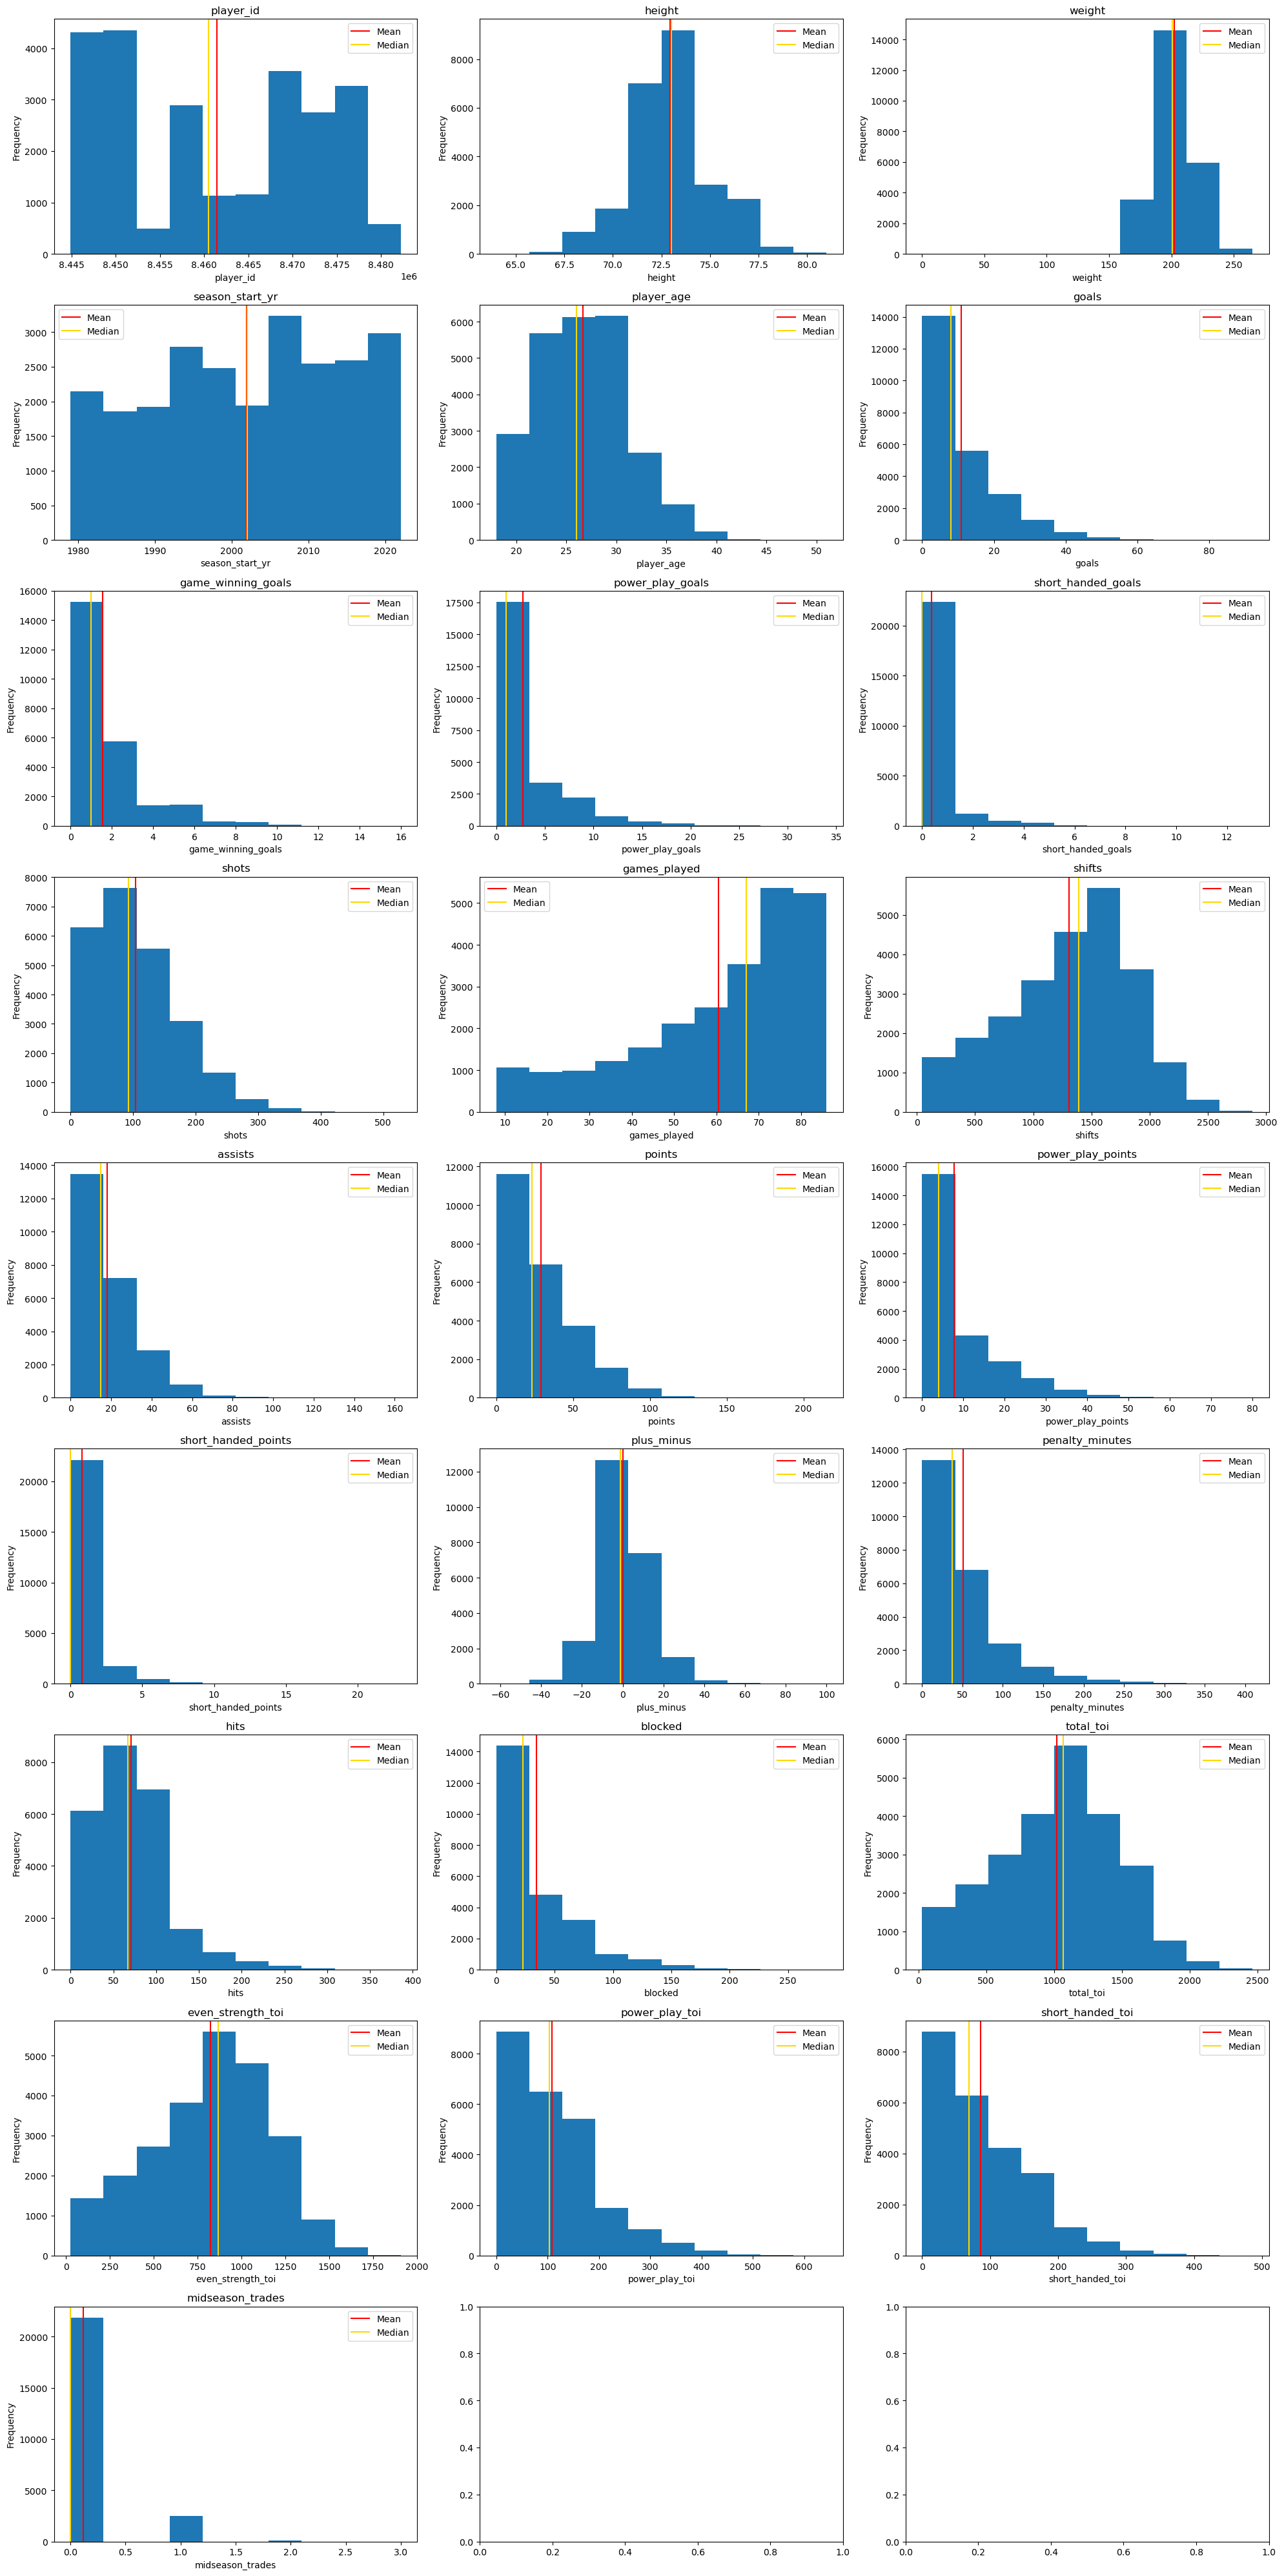

In [127]:
# Loop over the numeric columns and print a plot of subplots.
numeric_df = df.select_dtypes(include=['int', 'float'])

# Plot will have 9 rows, 3 subplots per row
plt.subplots(9, 3, figsize=(20,40))

# Creating the for loop
for slot_num, each_column in enumerate(numeric_df.columns, start=1):
    
    # Creating a hist for every iteration
    plt.subplot(9,3,slot_num)
    plt.hist(numeric_df[each_column], bins=10)
    
    # Set the titles and labels
    plt.title(each_column)
    plt.xlabel(each_column)
    plt.ylabel('Frequency')
    
    # Adding median and mean lines
    plt.axvline(numeric_df[each_column].mean(), c='red', label='Mean')
    plt.axvline(numeric_df[each_column].median(), c='gold', label='Median')
    plt.legend()
    
plt.tight_layout()

plt.show()

The skew of the `weight` distribution is concerning:  it suggests there are some values of `weight` that are zero.  Check:

In [128]:
df[df['weight']==0]

,player_id,name,height,weight,position_name,position_type,season_start_yr,player_age,franchise,goals,game_winning_goals,power_play_goals,short_handed_goals,shots,games_played,shifts,assists,points,power_play_points,short_handed_points,plus_minus,penalty_minutes,hits,blocked,total_toi,even_strength_toi,power_play_toi,short_handed_toi,midseason_trades
4865,8448882,Ross Lonsberry,70,0,Left Wing,Forward,1979,32,PIT,15.0,0.0,2.0,0.0,135.0,76,1453.909217,18.0,33.0,4.0,1.0,-4.0,36,91.519876,21.560024,1107.186337,910.607604,129.238609,67.340344,0
4866,8448882,Ross Lonsberry,70,0,Left Wing,Forward,1980,33,PIT,17.0,2.0,7.0,1.0,161.0,80,1530.430754,33.0,50.0,18.0,2.0,-3.0,76,96.336711,22.694762,1165.459302,958.534320,136.040641,70.884572,0


It's Ross Lonsberry again.  According to hockeydb.com, his weight is/was 185 lbs.  Put that into the DataFrame

In [129]:
df.loc[df['weight'] == 0, 'weight'] = 185
df[df['weight']==0]

,player_id,name,height,weight,position_name,position_type,season_start_yr,player_age,franchise,goals,game_winning_goals,power_play_goals,short_handed_goals,shots,games_played,shifts,assists,points,power_play_points,short_handed_points,plus_minus,penalty_minutes,hits,blocked,total_toi,even_strength_toi,power_play_toi,short_handed_toi,midseason_trades


Fixed, and replot the distribution.

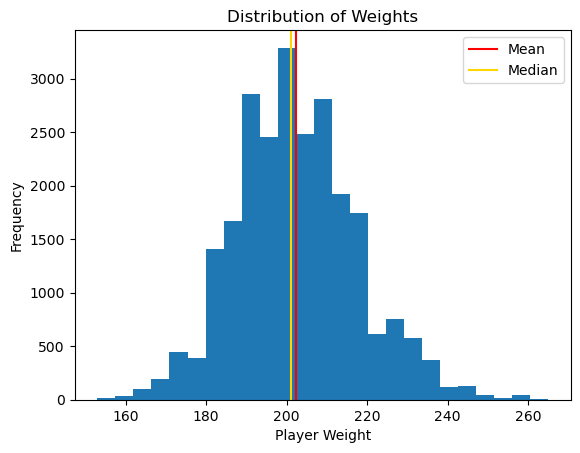

In [136]:
# Creating a hist for weight
plt.figure()
plt.hist(df['weight'], bins=25)

# Set the titles and labels
plt.title('Distribution of Weights')
plt.xlabel('Player Weight')
plt.ylabel('Frequency')

# Adding median and mean lines
plt.axvline(df['weight'].mean(), c='red', label='Mean')
plt.axvline(df['weight'].median(), c='gold', label='Median')
plt.legend()

plt.show()

That's better, the skew has been removed.

The distribution for player age looks a bit suspect, but this could be a function of wide bins - check the distribution with a higher bin count.

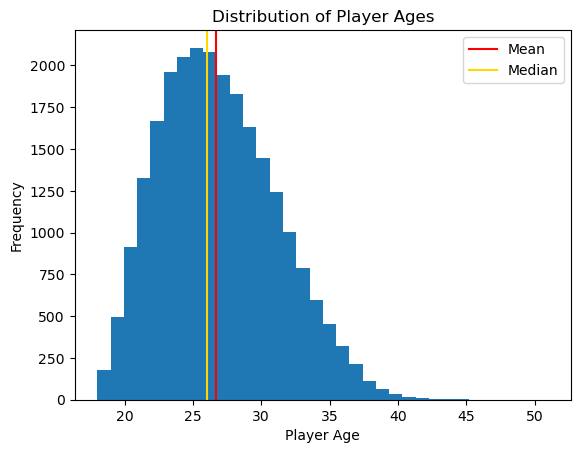

In [144]:
# Creating a hist for player_age
plt.figure()
plt.hist(df['player_age'], bins=34)

# Set the titles and labels
plt.title('Distribution of Player Ages')
plt.xlabel('Player Age')
plt.ylabel('Frequency')

# Adding median and mean lines
plt.axvline(df['player_age'].mean(), c='red', label='Mean')
plt.axvline(df['player_age'].median(), c='gold', label='Median')
plt.legend()

plt.show()

In [139]:
df['player_age'].value_counts()

player_age
25    2106
26    2082
24    2053
23    1962
27    1941
28    1827
22    1667
29    1633
30    1449
21    1324
31    1243
32    1004
20     916
33     790
34     599
19     494
35     454
36     321
37     212
18     176
38     111
39      67
40      35
41      16
42       9
43       5
44       3
45       2
46       1
51       1
Name: count, dtype: int64

The distribution checks out.  Nothing to adjust here.

## *Checkpoint*
**Save:**

In [145]:
df.shape

(24503, 29)

In [146]:
# Save progress
#df.to_csv('NHL_data_condensed_5.csv', index=False)

**Load:**

In [2]:
# Load the data back in
df = pd.read_csv('NHL_data_condensed_5.csv')
df = df.sort_values(by=['player_id', 'season_start_yr'])
df.reset_index(drop=True, inplace=True)
df.shape

(24503, 29)

#### Era Adjustment

Era adjustment is a processing step to be completed at a later data.  Below is a brief explainer / roadmap of the process. 

The first step in this process is to calculate a schedule adjustment for each player. In order to do this, divide 82 by the number of scheduled games per team. In 1952-53 the NHL played a 70-game schedule, so the schedule adjustment is 82 / 70 = 1.17.

The roster size adjustment is computed by dividing the maximum roster size for the season in question by 18. Teams were allowed to carry a maximum of 16 skaters at home and 15 skaters on the road during the 1952-53 season, so the roster size adjustment is 15.5 / 18 = 0.86.

Next calculate the era adjustment, which we will do by dividing 6 by the league average goals per game without the player in question. In 1952-53 a total of 1006 goals were scored in 210 games. Without Howe this works out to (1006 - 49) / 210 = 4.56 goals per game, so our era adjustment is 6 / 4.56 = 1.32.

Finally, we put everything together. Take the player's actual goals and multiply by the adjustments we computed above. For Howe in 1952-53 this is 49 * 1.17 * 0.86 * 1.32 = 65 adjusted goals.

In [2]:
# # create logic statement for calculating era adjust scoring
# # schedule adjustmnet already done by now

# # roster size adjustment
# k_roster = 17/18

# # era adjustment - need to import leage averages csv file
# league_df = pd.read_csv('league_avg_stats.csv')
# # k_era = 

0.9444444444444444

### Modelling Target Variable
The target variable of the modelling will be number of goals scored in a full season - this data is stored in the 'goals' column.  Let's plot the distribution as a reference.  Note that for the sake of modelling this distribution, we will consider any value of `games_played` that is above 78 a full season --> a full season is 82 games, so 78 games is the 95th percentile.


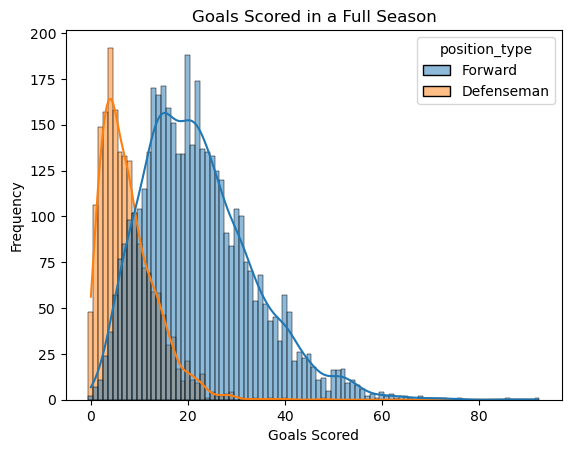

In [36]:
full_season_goals = df[df['games_played']>=78]

# Creating a hist for player_age
plt.figure()
sns.histplot(full_season_goals, x=full_season_goals['goals'], bins=47, discrete=True, kde=True, \
             hue=full_season_goals['position_type'])

# Set the titles and labels
plt.title('Goals Scored in a Full Season')
plt.xlabel('Goals Scored')
plt.ylabel('Frequency')
#plt.yscale('log')

plt.show()